In [ ]:
# Enhanced NSGA-II Flood Mitigation with Integrated Google Earth Engine Data Fetching
!pip install rasterio geopandas shapely scikit-image deap folium leafmap matplotlib pandas localtileserver earthengine-api geemap -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 22.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 567.6/567.6 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 23.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.7/220.7 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 46.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 29.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.4/41.4 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 269.0/269.0 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.6/108.6 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 

In [ ]:
# Cell 1: Environment Setup & Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from deap import base, creator, tools, algorithms
import random
import rasterio
from rasterio.plot import show
from rasterio.mask import mask
import geopandas as gpd
from shapely.geometry import box, Point, Polygon
import folium
import leafmap.foliumap as leafmap
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.cm as cm
from sklearn.preprocessing import MinMaxScaler
import itertools
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
from matplotlib import gridspec
import io
from PIL import Image
import os
import ee
import geemap
from ipywidgets import widgets
from IPython.display import display
import random
import numpy as np
from google.colab import drive
import time

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)

# Configuration parameters
GRID_SIZE = 1000  # 1 km grid size
POPULATION_SIZE = 300  # Increased population size for better exploration
NUM_GENERATIONS = 80  # More generations for improved convergence
CROSSOVER_PROB = 0.7  # High to encourage exploration
MUTATION_PROB = 0.3  # Moderate to prevent disrupting good solutions
MIN_DISTANCE = 1000  # Minimum distance between selected patches in meters
NUM_PATCHES_TO_SELECT = 5  # Number of patches to select from the Pareto front

print("Configuration and parameters set!")

Configuration and parameters set!


In [ ]:
# Cell 1: Environment Setup & Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from deap import base, creator, tools, algorithms
import random
import rasterio
from rasterio.plot import show
from rasterio.mask import mask
import geopandas as gpd
from shapely.geometry import box, Point, Polygon
import folium
import leafmap.foliumap as leafmap
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.cm as cm
from sklearn.preprocessing import MinMaxScaler
import itertools
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
from matplotlib import gridspec
import io
from PIL import Image
import os
import ee
import geemap
from ipywidgets import widgets
from IPython.display import display
import random
import numpy as np

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)


In [ ]:
# Cell 2: Google Earth Engine Authentication and Data Fetching

import os
import ee
import requests

def authenticate_gee():
    """Authenticate Google Earth Engine"""
    try:
        ee.Initialize()
        print("✅ Google Earth Engine already authenticated")
    except Exception:
        print("🔐 Authenticating Google Earth Engine...")
        ee.Authenticate()
        ee.Initialize(project='ee-marcosnavarretepardo')
        print("✅ Google Earth Engine authenticated successfully")

In [ ]:
# Cell 2.2:

def create_study_region(center_lon, center_lat, buffer_km=10):
    """Create a study region (buffer_km km around a point) in WGS84."""
    point = ee.Geometry.Point([center_lon, center_lat])
    region = (point
              .transform('EPSG:32630', 1)
              .buffer(buffer_km * 1000)
              .bounds()
              .transform('EPSG:4326', 1))
    return region

def download_gee_data(region, output_folder='gee_data'):
    """Download all required layers from GEE, with correct region serialization."""
    os.makedirs(output_folder, exist_ok=True)
    print("📡 Starting download for region:", region.getInfo())

    proj30 = ee.Projection('EPSG:32630').atScale(30)
    layers = {}

    # 0. STUDY AREA MASK (constant 1 over the entire region)
    study_area = (ee.Image.constant(1)
                  .clip(region)
                  .rename('study_area')
                  .reproject(crs=proj30, scale=30))
    layers['study_area'] = study_area


    # Urban proximity
    urban_mask = ee.Image("DLR/WSF/WSF2015/v1").select('WSF')\
                    .clip(region).gt(0).rename('urban')
    wsf = ee.Image("DLR/WSF/WSF2015/v1").select('WSF').gt(0).selfMask()
    dist = (wsf
            .clip(region)
            .fastDistanceTransform(256, 'pixels', 'squared_euclidean')
            .sqrt().multiply(30)
            .reproject(crs=proj30, scale=30))
    norm_dist = dist.min(2500).divide(2500)
    urban_proximity = (norm_dist.multiply(-1).add(1)
                       .clip(region)
                       .unmask(0)
                       .rename('urbanProximity')
                       .reproject(crs=proj30, scale=30))
    urban_proximity = urban_proximity.where(urban_mask.eq(1), 0)
    layers['urbanProximity'] = urban_proximity

    # Slope (inverted: flat=1, steep=0)
    dem = (ee.ImageCollection("COPERNICUS/DEM/GLO30")
           .filterBounds(region)
           .mosaic()
           .select('DEM')
           .clip(region))
    slope = ee.Terrain.slope(dem)
    slope_norm = slope.unitScale(0, 60)
    slope_inv = (ee.Image(1)
                 .subtract(slope_norm)
                 .unmask(1)
                 .rename('slope')
                 .reproject(crs=proj30, scale=30))
    layers['slope'] = slope_inv

    # Soil suitability
    def remap_soil(img):
        return img.remap(
            [1,2,3,4,5,6,7,8,9,10,11,12],
            [0.3,0.2,0.2,0.7,0.6,0.6,1.0,0.9,0.8,0.6,0.4,0.1],
            0
        )
    soil0 = remap_soil(ee.Image("OpenLandMap/SOL/SOL_TEXTURE-CLASS_USDA-TT_M/v02")
                       .select('b0').clip(region))
    soil30 = remap_soil(ee.Image("OpenLandMap/SOL/SOL_TEXTURE-CLASS_USDA-TT_M/v02")
                        .select('b30').clip(region))
    soil = (soil0.add(soil30).divide(2)
            .clip(region)
            .unmask(0)
            .rename('soil')
            .reproject(crs=proj30, scale=30))
    layers['soil'] = soil

    # Landcover suitability
    lc = ee.Image("COPERNICUS/CORINE/V20/100m/2018")\
           .select('landcover').clip(region)
    lc_suit = lc.remap(
        [111,112,121,122,131,141,211,212,221,231,242,243,311,312,313,321,322,324,331,511,523],
        [0.0,0.1,0.0,0.0,0.2,0.4,0.7,0.6,0.5,0.8,0.6,0.8,0.0,0.0,0.0,0.8,0.6,0.5,0.1,0.0,0.0],
        0
    ).clip(region).unmask(0).rename('landcoverSuitability')\
     .reproject(crs=proj30, scale=30)
    layers['landcoverSuitability'] = lc_suit

    # Flood risk (dynamic normalization)
    flood = ee.ImageCollection("JRC/CEMS_GLOFAS/FloodHazard/v1")\
             .select('depth').max().clip(region).unmask(0)
    stats = flood.reduceRegion(
        reducer=ee.Reducer.max(),
        geometry=region,
        scale=30,
        maxPixels=1e13
    )
    region_max = ee.Number(stats.get('depth')).max(1)
    flood_risk = flood.divide(region_max)\
                     .rename('floodRisk')\
                     .reproject(crs=proj30, scale=30)
    layers['floodRisk'] = flood_risk

    # Serialize region to GeoJSON
    region_geojson = region.getInfo()

    # Download all layers
    downloaded = {}
    for name, img in layers.items():
        print(f"   Downloading {name}...")
        url = img.getDownloadURL({
            'region': region_geojson,
            'scale': 30,
            'crs': 'EPSG:32630',
            'format': 'GEO_TIFF'
        })
        resp = requests.get(url)
        if resp.status_code == 200:
            file_path = os.path.join(output_folder, f"{name}.tif")
            with open(file_path, 'wb') as f:
                f.write(resp.content)
            downloaded[name] = file_path
            print(f"   ✅ {name} saved to {file_path}")
        else:
            print(f"   ❌ Failed to download {name} (HTTP {resp.status_code})")

    print("🎉 All layers downloaded.")
    return downloaded, region_geojson


In [ ]:
# Cell 3: Initialize, Authenticate, and Download Data

from google.colab import drive

def setup_data_automatically(center_lon=2.9862, center_lat=42.0553, buffer_km=10):
    """Authenticate, build region, and download all GEE layers."""
    print("🚀 Starting automatic data setup...")

    # 1. Authenticate Earth Engine
    authenticate_gee()

    # 2. Create study region
    region = create_study_region(center_lon, center_lat, buffer_km)
    print(f"📍 Study region: lon={center_lon}, lat={center_lat}, buffer={buffer_km}km")

    # 3. Download all layers
    files, region_geojson = download_gee_data(region)
    print("✅ Data download complete.")

    return files, region_geojson

# Optional: mount Google Drive for backups
try:
    drive.mount('/content/drive')
    print("📁 Google Drive mounted at /content/drive")
except Exception:
    print("⚠️ Google Drive not mounted (optional)")

# Run the setup to fetch and save all rasters
files, study_region_geojson = setup_data_automatically()
print("Downloaded files:", files)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
📁 Google Drive mounted at /content/drive
🚀 Starting automatic data setup...
🔐 Authenticating Google Earth Engine...
✅ Google Earth Engine authenticated successfully
📍 Study region: lon=2.9862, lat=42.0553, buffer=10km
📡 Starting download for region: {'type': 'Polygon', 'coordinates': [[[2.866011200257436, 41.965345870120885], [2.9262106820100846, 41.965345870120885], [2.9864101637627334, 41.965345870120885], [3.0466096455153817, 41.965345870120885], [3.1068091272680305, 41.965345870120885], [3.1068091272680305, 42.14528865610898], [3.0466096455153817, 42.14528865610898], [2.9864101637627334, 42.14528865610898], [2.9262106820100846, 42.14528865610898], [2.866011200257436, 42.14528865610898], [2.866011200257436, 41.965345870120885]]]}
   ✅ study_area saved to gee_data/study_area.tif
   ✅ urbanProximity saved to gee_data/urbanProximity.tif
   ✅ slope saved to ge

In [ ]:
# Cell 4: Loading & Checking Rasters (Enhanced with Min/Max & NaN checks)
import numpy as np

def load_and_check_rasters(file_paths):
    """Load raster files and check their properties, including min/max and NaN share."""
    rasters = {}
    print("Loading and checking raster files:")

    for name, path in file_paths.items():
        try:
            src = rasterio.open(path)
            rasters[name] = src
            arr = src.read(1).astype(float)  # read first band as float
            # Mask out the nodata
            if src.nodata is not None:
                arr[arr == src.nodata] = np.nan

            valid = np.isfinite(arr)
            pct_nan = 100 * (1 - valid.sum() / arr.size)

            print(f"✓ {name}:")
            print(f"    Shape:   {src.shape}")
            print(f"    Bounds:  {src.bounds}")
            print(f"    CRS:     {src.crs}")
            print(f"    Min/Max: {np.nanmin(arr):.4f} / {np.nanmax(arr):.4f}")
            print(f"    NaN%:    {pct_nan:.1f}%\n")
        except Exception as e:
            print(f"✗ {name}: Failed to load - {e}\n")

    # Compatibility check
    if len(rasters) > 1:
        first = next(iter(rasters.values()))
        same_shape = all(r.shape == first.shape for r in rasters.values())
        same_crs   = all(r.crs    == first.crs   for r in rasters.values())
        print("Compatibility Check:")
        print(f"  Same shape: {'✓' if same_shape else '✗'}")
        print(f"  Same CRS:   {'✓' if same_crs   else '✗'}")
        if not (same_shape and same_crs):
            print("  ⚠️  Warning: Some rasters differ in shape or CRS.\n")

    return rasters

# Load rasters and run the enhanced checks
rasters = load_and_check_rasters(files)

Loading and checking raster files:
✓ study_area:
    Shape:   (714, 712)
    Bounds:  BoundingBox(left=984780.0, bottom=4662600.0, right=1006140.0, top=4684020.0)
    CRS:     EPSG:32630
    Min/Max: 1.0000 / 1.0000
    NaN%:    0.0%

✓ urbanProximity:
    Shape:   (714, 712)
    Bounds:  BoundingBox(left=984780.0, bottom=4662600.0, right=1006140.0, top=4684020.0)
    CRS:     EPSG:32630
    Min/Max: 0.0000 / 0.9880
    NaN%:    0.0%

✓ slope:
    Shape:   (714, 712)
    Bounds:  BoundingBox(left=984780.0, bottom=4662600.0, right=1006140.0, top=4684020.0)
    CRS:     EPSG:32630
    Min/Max: 0.0000 / 1.0000
    NaN%:    0.0%

✓ soil:
    Shape:   (714, 712)
    Bounds:  BoundingBox(left=984780.0, bottom=4662600.0, right=1006140.0, top=4684020.0)
    CRS:     EPSG:32630
    Min/Max: 0.0000 / 1.0000
    NaN%:    0.0%

✓ landcoverSuitability:
    Shape:   (714, 712)
    Bounds:  BoundingBox(left=984780.0, bottom=4662600.0, right=1006140.0, top=4684020.0)
    CRS:     EPSG:32630
    Min/Ma

In [ ]:
# Cell 4: Creating Patch Grid
def create_patch_grid(raster, grid_size):
    """Create a grid of patches over the raster"""
    # Get raster bounds
    left, bottom, right, top = raster.bounds

    # Calculate number of cells in each direction
    num_cols = max(1, int((right - left) / grid_size))
    num_rows = max(1, int((top - bottom) / grid_size))

    # Create patches
    patches = []
    for row in range(num_rows):
        for col in range(num_cols):
            # Calculate patch bounds
            patch_left = left + col * grid_size
            patch_bottom = bottom + (num_rows - row - 1) * grid_size
            patch_right = patch_left + grid_size
            patch_top = patch_bottom + grid_size

            # Create polygon
            polygon = box(patch_left, patch_bottom, patch_right, patch_top)

            # Calculate centroid coordinates (important for your requirement)
            centroid = polygon.centroid

            # Add to patches
            patches.append({
                'id': row * num_cols + col,
                'geometry': polygon,
                'centroid_x': centroid.x,
                'centroid_y': centroid.y,
                'row': row,
                'col': col
            })

    # Create GeoDataFrame
    patches_gdf = gpd.GeoDataFrame(patches, geometry='geometry', crs=raster.crs)

    print(f"Created grid with {len(patches_gdf)} patches")
    return patches_gdf

# Create grid from the study area raster
patch_grid = create_patch_grid(rasters['study_area'], GRID_SIZE)

Created grid with 441 patches


In [ ]:
# Cell 5: Extracting Patch Statistics
def extract_patch_statistics(patch_grid, rasters):
    """Extract statistics for each patch from all rasters"""
    # Initialize columns in the GeoDataFrame
    for raster_name in rasters.keys():
        patch_grid[raster_name] = np.nan

    # Loop through patches
    for idx, patch in patch_grid.iterrows():
        geom = [patch.geometry]

        # Extract values from each raster
        for raster_name, raster in rasters.items():
            try:
                # Mask the raster with the patch geometry
                out_image, out_transform = mask(raster, geom, crop=True)

                # Calculate mean value (excluding nodata values)
                data = out_image[0]
                valid_data = data[data != raster.nodata] if raster.nodata is not None else data

                if len(valid_data) > 0:
                    # Store mean value
                    patch_grid.at[idx, raster_name] = valid_data.mean()
                else:
                    patch_grid.at[idx, raster_name] = np.nan
            except Exception as e:
                print(f"Error extracting statistics for patch {idx}, raster {raster_name}: {str(e)}")
                patch_grid.at[idx, raster_name] = np.nan

    # Drop patches with NaN values
    valid_patches = patch_grid.dropna(subset=list(rasters.keys()))
    print(f"Valid patches after removing NaN values: {len(valid_patches)} out of {len(patch_grid)}")

    # Safety check: ensure we have at least 1 valid patch
    if len(valid_patches) == 0:
        print("WARNING: No valid patches found! Check if your raster files overlap with the grid.")
        print("Using patches with at least some valid values...")

        # Instead of requiring all rasters to have values, accept patches that have at least some values
        # This is a fallback strategy for when strict filtering yields no results
        valid_count = patch_grid.count(axis=1)
        valid_patches = patch_grid[valid_count > len(rasters.keys()) / 2]  # At least half of the rasters have values

        # If still no valid patches, just take the first few with any values
        if len(valid_patches) == 0:
            valid_patches = patch_grid[valid_count > 0].head(10)  # Take first 10 patches with any values
            print(f"Using {len(valid_patches)} patches with at least some valid values as fallback")

            # Fill remaining NaN values with means
            for col in list(rasters.keys()):
                if valid_patches[col].isna().any():
                    mean_val = valid_patches[col].mean()
                    if np.isnan(mean_val):  # If still NaN, use 0
                        valid_patches[col] = valid_patches[col].fillna(0)
                    else:
                        valid_patches[col] = valid_patches[col].fillna(mean_val)

    # Verify we have at least 2 patches for the algorithm to work
    if len(valid_patches) < 2:
        raise ValueError("Not enough valid patches for optimization. Check your raster files.")

    print(f"Final valid patches for optimization: {len(valid_patches)}")
    return valid_patches

# Extract statistics for each patch
valid_patches = extract_patch_statistics(patch_grid, rasters)

# Display the first few rows of valid patches to verify data
print("\nPreview of valid patches data:")
display(valid_patches[['centroid_x', 'centroid_y'] + list(rasters.keys())].head())

Valid patches after removing NaN values: 140 out of 441
Final valid patches for optimization: 140

Preview of valid patches data:


centroid_x  centroid_y  study_area  urbanProximity     slope      soil  \
16   1001280.0   4683100.0         1.0        0.650705  0.970588  0.785943   
17   1002280.0   4683100.0         1.0        0.672064  0.942042  0.802422   
18   1003280.0   4683100.0         1.0        0.777637  0.942042  0.893512   
19   1004280.0   4683100.0         1.0        0.823272  0.953287  0.937716   
20   1005280.0   4683100.0         1.0        0.001678  0.001730  0.001730   

    landcoverSuitability  floodRisk  
16              0.532093   0.060271  
17              0.510294   0.118180  
18              0.565225   0.174355  
19              0.571972   0.228173  
20              0.001038   0.239006

MCDA Weights: {'slope': np.float64(0.16666666666666666), 'landcoverSuitability': np.float64(0.16666666666666666), 'soil': np.float64(0.16666666666666666), 'urbanProximity': np.float64(0.16666666666666666), 'floodRisk': np.float64(0.3333333333333333)}


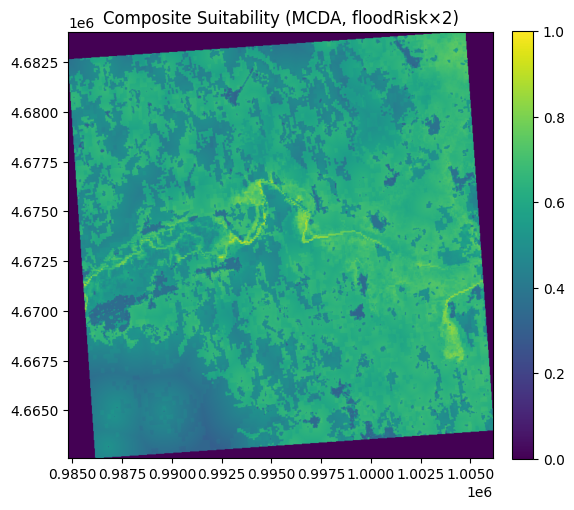

In [ ]:
# --- MCDA with MinMax Normalization and Double Flood Risk Weight ---

import numpy as np
import matplotlib.pyplot as plt
import os
import rasterio
import rasterio.plot
from sklearn.preprocessing import MinMaxScaler

# --- MCDA with MinMax Normalization and Double Flood Risk Weight ---

# Use the exact keys from your `rasters` dict:
layer_names = ['slope', 'landcoverSuitability', 'soil', 'urbanProximity', 'floodRisk']

# Assign weights (double for floodRisk)
raw_weights = np.array([1, 1, 1, 1, 2], dtype=float)
weights = raw_weights / raw_weights.sum()
print("MCDA Weights:", dict(zip(layer_names, weights)))

# Load rasters into arrays
layer_arrays = []
for name in layer_names:
    src = rasters[name]
    arr = src.read(1).astype(float)
    # mask nodata
    if src.nodata is not None:
        arr[arr == src.nodata] = np.nan
    layer_arrays.append(arr)

# MinMax normalize each layer
normalized_layers = []
for arr in layer_arrays:
    flat = arr.flatten()
    valid = ~np.isnan(flat)
    scaled_flat = np.full(flat.shape, np.nan)
    if valid.any():
        scaler = MinMaxScaler()
        scaled_flat[valid] = scaler.fit_transform(flat[valid].reshape(-1,1)).flatten()
    normalized_layers.append(scaled_flat.reshape(arr.shape))

# Stack and compute weighted composite
stack = np.stack(normalized_layers)  # shape (5, rows, cols)
composite = np.zeros_like(stack[0], dtype=float)
for i, arr in enumerate(stack):
    composite += weights[i] * np.nan_to_num(arr, nan=0)

# Mask to study area if needed
if 'study_area' in rasters:
    mask_arr = rasters['study_area'].read(1)
    composite = np.where(mask_arr != rasters['study_area'].nodata, composite, np.nan)

# Normalize composite for display
cmin, cmax = np.nanmin(composite), np.nanmax(composite)
composite_norm = (composite - cmin) / (cmax - cmin)

# Quick plot
plt.figure(figsize=(6,6))
extent = rasterio.plot.plotting_extent(rasters['floodRisk'])
im = plt.imshow(composite_norm, cmap='viridis', vmin=0, vmax=1, extent=extent)
plt.title("Composite Suitability (MCDA, floodRisk×2)")
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.show()

In [ ]:
# Normalize before optimization
from sklearn.preprocessing import MinMaxScaler

objective_cols = ['landcoverSuitability', 'slope', 'soil', 'floodRisk', 'urbanProximity']
scaler = MinMaxScaler()
valid_patches[objective_cols] = scaler.fit_transform(valid_patches[objective_cols])


In [ ]:
# Cell 6: Setting Up NSGA-II
# Create fitness class - we want to maximize all objectives for flood mitigation
creator.create("FitnessMulti", base.Fitness, weights=(1.0, 1.0, 1.0, 3.0, 1.0))
creator.create("Individual", list, fitness=creator.FitnessMulti)

def evaluate_individual(individual, patch_data):
    """Evaluate a patch (individual) for all objectives"""
    # Get patch index
    idx = individual[0]

    # Extract values for each objective
    landcover_val = patch_data.iloc[idx]['landcoverSuitability']
    slope_val = patch_data.iloc[idx]['slope']
    soil_val = patch_data.iloc[idx]['soil']
    flood_risk_val = patch_data.iloc[idx]['floodRisk']
    urban_proximity_val = patch_data.iloc[idx]['urbanProximity']

    # Return the objective values as a tuple
    return (landcover_val, slope_val, soil_val, flood_risk_val, urban_proximity_val)

# Custom mutation to ensure valid indices
def mutate_custom(individual, low, up):
    """Custom mutation that ensures the individual has a valid index"""
    # For our simple case with one index, just set to a random valid value
    individual[0] = random.randint(low, up)
    return individual,

# Custom crossover for single-index individuals
def crossover_custom(ind1, ind2):
    """Custom crossover for single-index individuals"""
    # For single-index individuals, we simply swap their values
    # This is effectively the same as a uniform crossover for 1-element lists
    ind1[0], ind2[0] = ind2[0], ind1[0]
    return ind1, ind2

# Initialize the toolbox
toolbox = base.Toolbox()

# Define individual and population
toolbox.register("indices", random.randint, 0, len(valid_patches) - 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.indices, n=1)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Register genetic operators
toolbox.register("evaluate", evaluate_individual, patch_data=valid_patches)
toolbox.register("mate", crossover_custom)  # Use our custom crossover
toolbox.register("mutate", mutate_custom, low=0, up=len(valid_patches) - 1)  # Use our custom mutation
toolbox.register("select", tools.selNSGA2)

print("NSGA-II setup complete!")

NSGA-II setup complete!


In [ ]:
# Cell 7: Define Spatial Filtering Function
def select_spatially_distributed_patches(population, patch_data, min_distance, num_to_select):
    """Select a subset of patches that are spatially distributed"""
    print("Selecting spatially distributed patches...")

    # Extract unique individuals from the population
    # This helps prevent the "empty range for randrange" error
    unique_individuals = {}
    for ind in population:
        idx = ind[0]
        if idx not in unique_individuals:
            unique_individuals[idx] = ind

    # Convert to list for sorting
    unique_inds = list(unique_individuals.values())

    # We need individuals with valid fitness values
    valid_inds = [ind for ind in unique_inds if hasattr(ind, 'fitness') and ind.fitness.valid]

    if len(valid_inds) == 0:
        print("Warning: No valid individuals found in the population!")
        # Return some random individuals as a fallback
        random_indices = np.random.choice(len(patch_data), min(10, len(patch_data)), replace=False)
        fallback_inds = []
        for idx in random_indices:
            ind = creator.Individual([idx])
            ind.fitness.values = evaluate_individual(ind, patch_data)
            fallback_inds.append(ind)
        valid_inds = fallback_inds

    # Sort by sum of fitness values (simple ranking)
    valid_inds.sort(key=lambda ind: sum(ind.fitness.values), reverse=True)

    # Get centroids for all patches
    selected_patches = []
    selected_centroids = []

    # Always select the best patch first
    if len(valid_inds) > 0:
        best_patch = valid_inds[0]
        best_idx = best_patch[0]
        best_centroid = np.array([[
            patch_data.iloc[best_idx]['centroid_x'],
            patch_data.iloc[best_idx]['centroid_y']
        ]])

        selected_patches.append(best_patch)
        selected_centroids = best_centroid

    # Loop through remaining patches and add them if they're far enough from already selected patches
    for patch in valid_inds[1:]:
        if len(selected_patches) >= num_to_select:
            break

        idx = patch[0]
        centroid = np.array([[
            patch_data.iloc[idx]['centroid_x'],
            patch_data.iloc[idx]['centroid_y']
        ]])

        # Calculate distances to all already selected patches
        if len(selected_centroids) > 0:
            distances = cdist(centroid, selected_centroids).min()

            # If this patch is far enough from all selected patches, add it
            if distances >= min_distance:
                selected_patches.append(patch)
                selected_centroids = np.vstack([selected_centroids, centroid])

    print(f"Selected {len(selected_patches)} spatially distributed patches")

    # If we didn't get enough patches, relax the distance constraint
    if len(selected_patches) < min(num_to_select, 10):
        print("Not enough patches selected. Relaxing distance constraint...")
        relaxed_distance = min_distance / 2

        for patch in valid_inds:
            if patch in selected_patches:
                continue

            if len(selected_patches) >= num_to_select:
                break

            idx = patch[0]
            centroid = np.array([[
                patch_data.iloc[idx]['centroid_x'],
                patch_data.iloc[idx]['centroid_y']
            ]])

            # Calculate distances to all already selected patches
            if len(selected_centroids) > 0:
                distances = cdist(centroid, selected_centroids).min()

                # If this patch is far enough (with relaxed constraint) from all selected patches, add it
                if distances >= relaxed_distance:
                    selected_patches.append(patch)
                    selected_centroids = np.vstack([selected_centroids, centroid])

        print(f"After relaxing distance constraint: Selected {len(selected_patches)} patches")

    return selected_patches

print("Spatial filtering function defined!")
def run_nsga2(toolbox, pop_size, num_gen, cxpb, mutpb):
    """Run the NSGA-II algorithm"""
    print("Starting NSGA-II optimization...")

    # Create initial population
    pop = toolbox.population(n=pop_size)

    # Evaluate initial population
    fitnesses = list(map(toolbox.evaluate, pop))
    for ind, fit in zip(pop, fitnesses):
        ind.fitness.values = fit

    # Track statistics for each generation
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean, axis=0)
    stats.register("min", np.min, axis=0)
    stats.register("max", np.max, axis=0)

    # Create the hall of fame (to store the best individuals)
    hof = tools.HallOfFame(maxsize=pop_size)

    # Run the algorithm with NSGA-II selection - using a custom evolution loop
    # This gives us more control and helps avoid the randrange error
    for gen in range(num_gen):
        # Select the next generation individuals
        offspring = toolbox.select(pop, len(pop))

        # Clone the selected individuals
        offspring = list(map(toolbox.clone, offspring))

        # Apply crossover and mutation on the offspring
        for i in range(1, len(offspring), 2):
            if random.random() < cxpb:
                offspring[i-1], offspring[i] = toolbox.mate(offspring[i-1], offspring[i])
                del offspring[i-1].fitness.values
                del offspring[i].fitness.values

        for i in range(len(offspring)):
            if random.random() < mutpb:
                offspring[i], = toolbox.mutate(offspring[i])
                del offspring[i].fitness.values

        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        # Update the hall of fame with the generated individuals
        hof.update(offspring)

        # Replace the current population by the offspring
        pop[:] = offspring

        # Append the current statistics to the logbook
        record = stats.compile(pop)
        print(f"Generation {gen+1}/{num_gen} - Avg: {record['avg']}")

    print("NSGA-II optimization complete!")
    return pop, hof

# Verify we have enough valid patches
print(f"Number of valid patches: {len(valid_patches)}")
if len(valid_patches) < 2:
    raise ValueError("Need at least 2 valid patches for the optimization to work!")

# Print range for random number generation
print(f"Random range will be from 0 to {len(valid_patches) - 1}")

# Run optimization multiple times and combine results
test_population_size = min(100, len(valid_patches))
test_generations = 20
num_runs = 5

print(f"Running {num_runs} optimizations with population size: {test_population_size}, generations: {test_generations}")

best_patches_all_runs = []
all_results = []

for run in range(num_runs):
    print(f"\n========== RUN {run + 1} of {num_runs} ==========")

    #Reset random seed for each run if you want different results, or comment out for truly random
    random.seed(42 + run)  # Different seed for each run
    np.random.seed(42 + run)

    # Run NSGA-II
    final_pop, hof = run_nsga2(
        toolbox=toolbox,
        pop_size=test_population_size,
        num_gen=test_generations,
        cxpb=CROSSOVER_PROB,
        mutpb=MUTATION_PROB
    )

    # Select spatially distributed patches
    selected = select_spatially_distributed_patches(
        final_pop,
        valid_patches,
        MIN_DISTANCE,
        NUM_PATCHES_TO_SELECT
    )

    # Store results from this run
    best_patches_all_runs.extend(selected)
    all_results.append(selected)

    print(f"Run {run + 1} completed: {len(selected)} patches selected")

Spatial filtering function defined!
Number of valid patches: 140
Random range will be from 0 to 139
Running 5 optimizations with population size: 100, generations: 20

========== RUN 1 of 5 ==========
Starting NSGA-II optimization...
Generation 1/20 - Avg: [0.62894336 0.87874349 0.82024957 0.20912983 0.78091676]
Generation 2/20 - Avg: [0.61782394 0.87579721 0.8187513  0.23947066 0.79033979]
Generation 3/20 - Avg: [0.59750334 0.8903726  0.8382656  0.24201841 0.80132854]
Generation 4/20 - Avg: [0.61954048 0.90355284 0.84504419 0.22666026 0.81369452]
Generation 5/20 - Avg: [0.57187684 0.86584921 0.80654289 0.24388179 0.79044671]
Generation 6/20 - Avg: [0.59042479 0.88279028 0.83047964 0.24034896 0.80719593]
Generation 7/20 - Avg: [0.6269797  0.88870882 0.8274948  0.23218031 0.81883516]
Generation 8/20 - Avg: [0.63725755 0.87402078 0.81354896 0.23556198 0.80233328]
Generation 9/20 - Avg: [0.61727224 0.87400345 0.81734012 0.21703873 0.79925176]
Generation 10/20 - Avg: [0.58840903 0.86611784

In [ ]:
# Cell 8: Running Multiple Optimizations for Consistency
from collections import Counter  # Import Counter here as safety measure

def run_nsga2(toolbox, pop_size, num_gen, cxpb, mutpb):
    """Run the NSGA-II algorithm"""
    print("Starting NSGA-II optimization...")

    # Create initial population
    pop = toolbox.population(n=pop_size)

    # Evaluate initial population
    fitnesses = list(map(toolbox.evaluate, pop))
    for ind, fit in zip(pop, fitnesses):
        ind.fitness.values = fit

    # Track statistics for each generation
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean, axis=0)
    stats.register("min", np.min, axis=0)
    stats.register("max", np.max, axis=0)

    # Create the hall of fame (to store the best individuals)
    hof = tools.HallOfFame(maxsize=pop_size)

    # Run the algorithm with NSGA-II selection - using a custom evolution loop
    # This gives us more control and helps avoid the randrange error
    for gen in range(num_gen):
        # Select the next generation individuals
        offspring = toolbox.select(pop, len(pop))

        # Clone the selected individuals
        offspring = list(map(toolbox.clone, offspring))

        # Apply crossover and mutation on the offspring
        for i in range(1, len(offspring), 2):
            if random.random() < cxpb:
                offspring[i-1], offspring[i] = toolbox.mate(offspring[i-1], offspring[i])
                del offspring[i-1].fitness.values
                del offspring[i].fitness.values

        for i in range(len(offspring)):
            if random.random() < mutpb:
                offspring[i], = toolbox.mutate(offspring[i])
                del offspring[i].fitness.values

        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        # Update the hall of fame with the generated individuals
        hof.update(offspring)

        # Replace the current population by the offspring
        pop[:] = offspring

        # Append the current statistics to the logbook
        record = stats.compile(pop)
        print(f"Generation {gen+1}/{num_gen} - Avg: {record['avg']}")

    print("NSGA-II optimization complete!")
    return pop, hof

# Verify we have enough valid patches
print(f"Number of valid patches: {len(valid_patches)}")
if len(valid_patches) < 2:
    raise ValueError("Need at least 2 valid patches for the optimization to work!")

# Print range for random number generation
print(f"Random range will be from 0 to {len(valid_patches) - 1}")

# Run optimization multiple times and combine results
test_population_size = min(100, len(valid_patches))
test_generations = 20
num_runs = 5

print(f"Running {num_runs} optimizations with population size: {test_population_size}, generations: {test_generations}")

best_patches_all_runs = []
all_results = []

for run in range(num_runs):
    print(f"\n========== RUN {run + 1} of {num_runs} ==========")

    # Reset random seed for each run if you want different results, or comment out for truly random
    random.seed(42 + run)  # Different seed for each run
    np.random.seed(42 + run)

    # Run NSGA-II
    final_pop, hof = run_nsga2(
        toolbox=toolbox,
        pop_size=test_population_size,
        num_gen=test_generations,
        cxpb=CROSSOVER_PROB,
        mutpb=MUTATION_PROB
    )

    # Select spatially distributed patches
    selected = select_spatially_distributed_patches(
        final_pop,
        valid_patches,
        MIN_DISTANCE,
        NUM_PATCHES_TO_SELECT
    )

    # Store results from this run
    best_patches_all_runs.extend(selected)
    all_results.append(selected)

    print(f"Run {run + 1} completed: {len(selected)} patches selected")

# Find patches that appear most frequently across all runs
print(f"\n========== ANALYZING CONSISTENCY ACROSS {num_runs} RUNS ==========")

patch_frequency = Counter([p[0] for p in best_patches_all_runs])
most_consistent_patches = patch_frequency.most_common(50)

print(f"Total unique patches found across all runs: {len(patch_frequency)}")
print(f"Most frequently selected patches:")
for i, (patch_idx, frequency) in enumerate(most_consistent_patches[:10]):
    print(f"  {i+1}. Patch {patch_idx}: appeared in {frequency}/{num_runs} runs ({frequency/num_runs*100:.1f}%)")

# Store the most consistent patches for further analysis
final_population = best_patches_all_runs  # Use all patches from all runs
selected_patches = [creator.Individual([patch_idx]) for patch_idx, freq in most_consistent_patches]

# Evaluate the most consistent patches
for patch in selected_patches:
    patch.fitness.values = evaluate_individual(patch, valid_patches)

print(f"\nUsing {len(selected_patches)} most consistent patches for final analysis.")

Number of valid patches: 140
Random range will be from 0 to 139
Running 5 optimizations with population size: 100, generations: 20

========== RUN 1 of 5 ==========
Starting NSGA-II optimization...
Generation 1/20 - Avg: [0.62894336 0.87874349 0.82024957 0.20912983 0.78091676]
Generation 2/20 - Avg: [0.61782394 0.87579721 0.8187513  0.23947066 0.79033979]
Generation 3/20 - Avg: [0.59750334 0.8903726  0.8382656  0.24201841 0.80132854]
Generation 4/20 - Avg: [0.61954048 0.90355284 0.84504419 0.22666026 0.81369452]
Generation 5/20 - Avg: [0.57187684 0.86584921 0.80654289 0.24388179 0.79044671]
Generation 6/20 - Avg: [0.59042479 0.88279028 0.83047964 0.24034896 0.80719593]
Generation 7/20 - Avg: [0.6269797  0.88870882 0.8274948  0.23218031 0.81883516]
Generation 8/20 - Avg: [0.63725755 0.87402078 0.81354896 0.23556198 0.80233328]
Generation 9/20 - Avg: [0.61727224 0.87400345 0.81734012 0.21703873 0.79925176]
Generation 10/20 - Avg: [0.58840903 0.86611784 0.81145624 0.24371339 0.79217511]
G

In [ ]:
# --- Run NSGA-II multiple times and store all Pareto fronts (HOF) ---

num_runs = 5
test_population_size = min(100, len(valid_patches))
test_generations = 20

hof_all_runs = []   # List of Hall of Fame (full Pareto fronts) per run
final_pops_all_runs = []  # Optional: to keep full populations, if needed

for run in range(num_runs):
    print(f"\n========== RUN {run + 1} of {num_runs} ==========")
    final_pop, hof = run_nsga2(
        toolbox=toolbox,
        pop_size=test_population_size,
        num_gen=test_generations,
        cxpb=CROSSOVER_PROB,
        mutpb=MUTATION_PROB
    )
    hof_all_runs.append(list(hof))  # Convert to list for later iteration
    final_pops_all_runs.append(final_pop)  # Optional, if you want all populations
    print(f"Run {run + 1} completed: {len(hof)} Pareto-optimal patches found")

print(f"\nStored {num_runs} complete Pareto fronts (no spatial filtering).")



========== RUN 1 of 5 ==========
Starting NSGA-II optimization...
Generation 1/20 - Avg: [0.60714801 0.89630848 0.8280052  0.2140549  0.80592223]
Generation 2/20 - Avg: [0.62237911 0.91371749 0.84927773 0.20811869 0.82719685]
Generation 3/20 - Avg: [0.63291611 0.8986655  0.84386222 0.21012428 0.80449654]
Generation 4/20 - Avg: [0.60564921 0.88779028 0.83516421 0.22457924 0.78700105]
Generation 5/20 - Avg: [0.60606465 0.88150779 0.8222162  0.22890271 0.78098394]
Generation 6/20 - Avg: [0.5988592  0.87876082 0.82753336 0.23520799 0.78015459]
Generation 7/20 - Avg: [0.61055971 0.89822356 0.84189168 0.21567322 0.78531466]
Generation 8/20 - Avg: [0.58701309 0.86010397 0.80318458 0.2280165  0.75440548]
Generation 9/20 - Avg: [0.59028587 0.8676343  0.8122604  0.22604307 0.78046937]
Generation 10/20 - Avg: [0.58067593 0.85821489 0.81266811 0.23414454 0.76528309]
Generation 11/20 - Avg: [0.63711996 0.88196706 0.82945104 0.22514473 0.79137687]
Generation 12/20 - Avg: [0.58886855 0.86597919 0.81

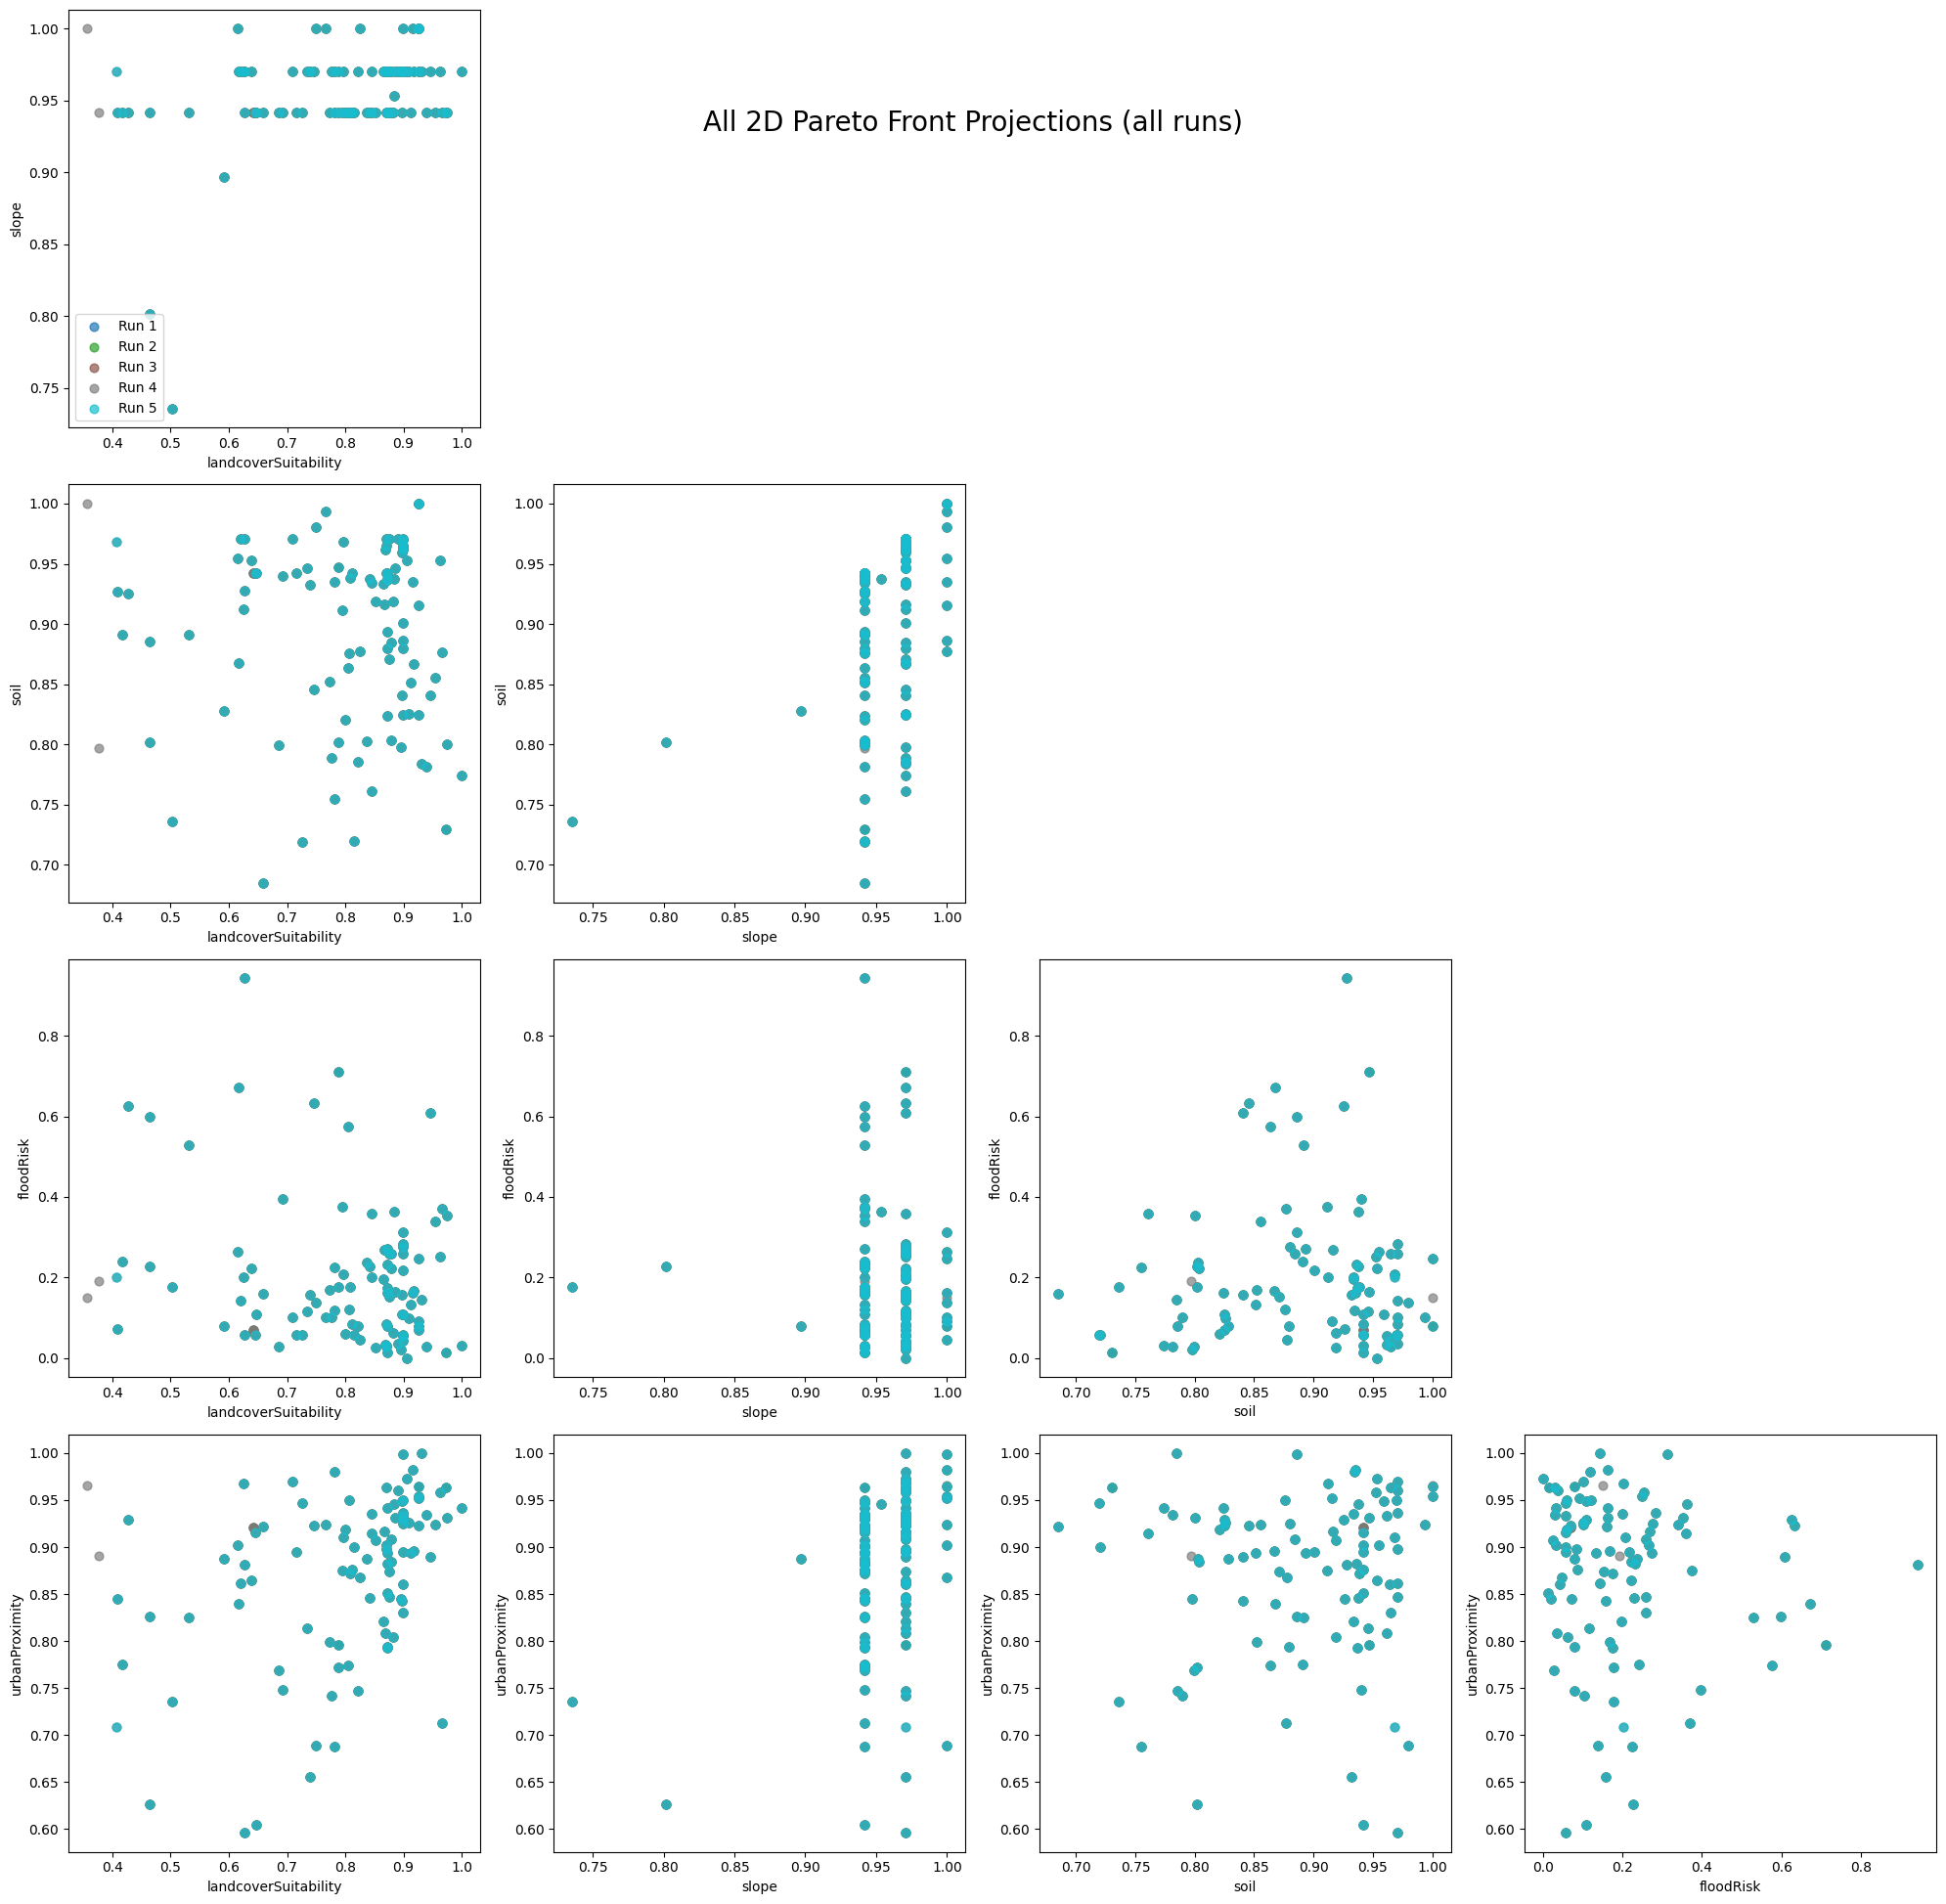

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import itertools

# List your objectives
objective_cols = ['landcoverSuitability', 'slope', 'soil', 'floodRisk', 'urbanProximity']
num_runs = len(hof_all_runs)
colors = plt.cm.tab10(np.linspace(0, 1, num_runs))

# Get all unique pairs of objectives (combinations)
pairs = list(itertools.combinations(objective_cols, 2))

# Set up a grid of subplots
n = len(objective_cols)
fig, axes = plt.subplots(n-1, n-1, figsize=(20, 20))
fig.suptitle("All 2D Pareto Front Projections (all runs)", fontsize=20, y=0.92)

# axes is a 2D array, but we'll only fill the lower triangle
for i, obj1 in enumerate(objective_cols[:-1]):
    for j, obj2 in enumerate(objective_cols[1:], start=1):
        if i < j:
            ax = axes[j-1, i]
            for run_idx, hof in enumerate(hof_all_runs):
                vals1 = [valid_patches.iloc[p[0]][obj1] for p in hof]
                vals2 = [valid_patches.iloc[p[0]][obj2] for p in hof]
                ax.scatter(vals1, vals2, color=colors[run_idx], s=40, label=f'Run {run_idx+1}', alpha=0.7)
            ax.set_xlabel(obj1)
            ax.set_ylabel(obj2)
            if i == 0 and j == 1:
                ax.legend()
        else:
            axes[j-1, i].axis('off')

plt.tight_layout()
plt.show()


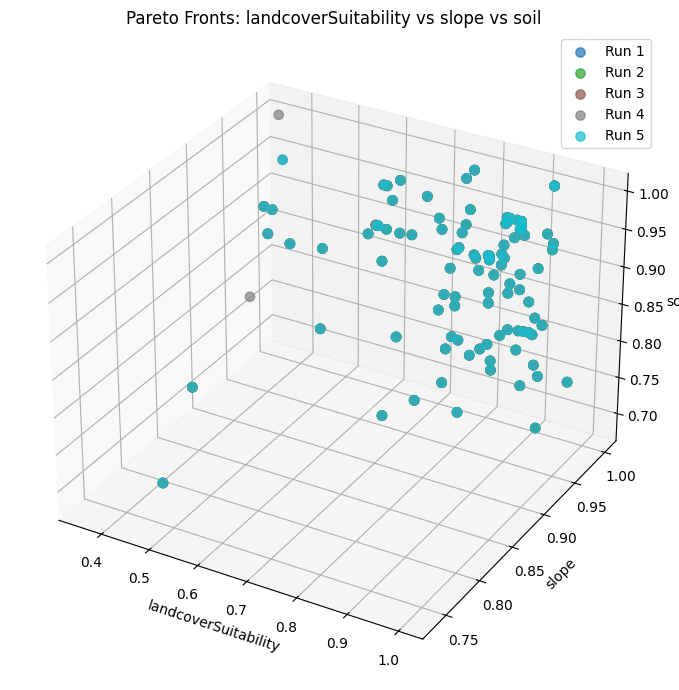

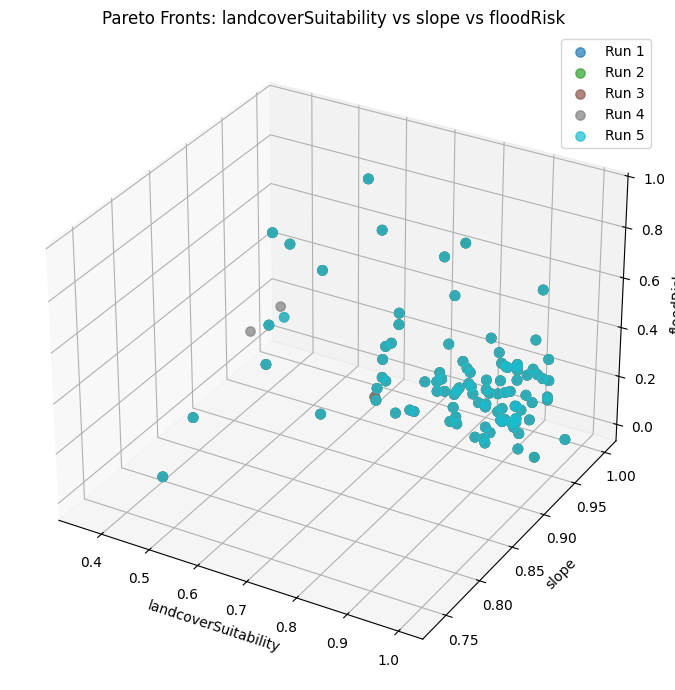

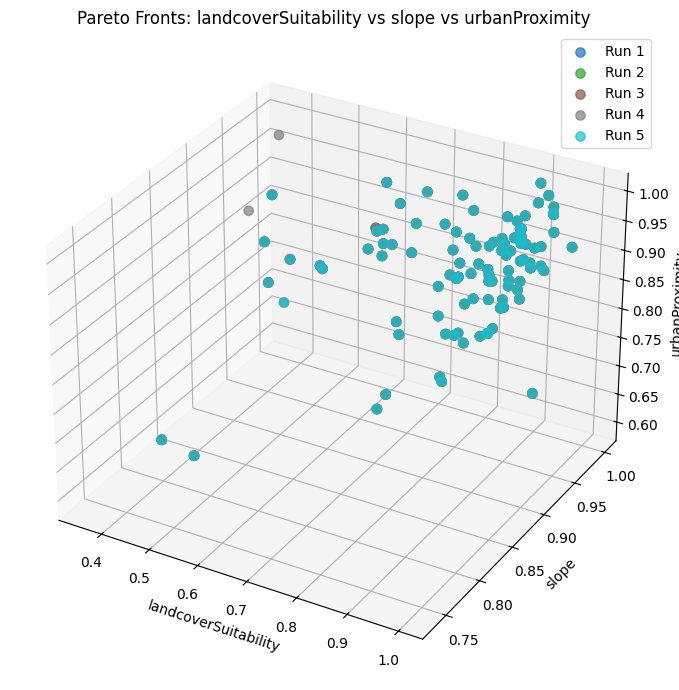

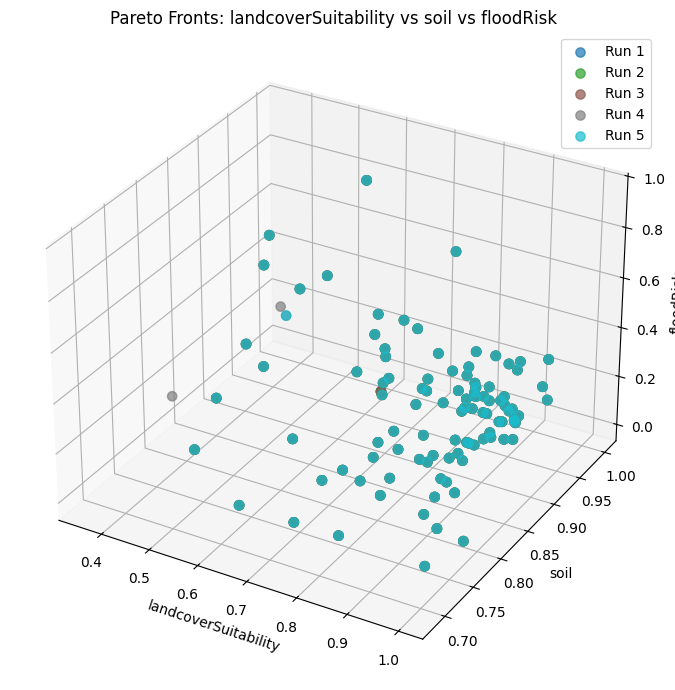

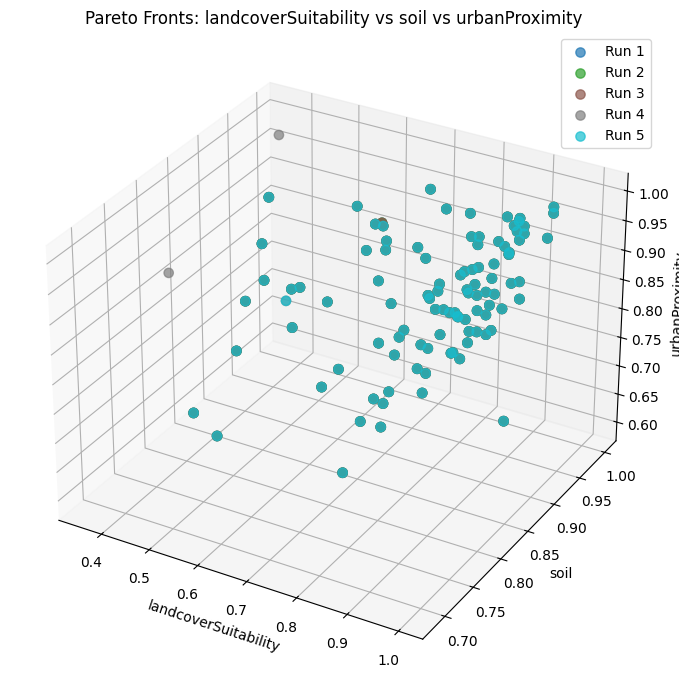

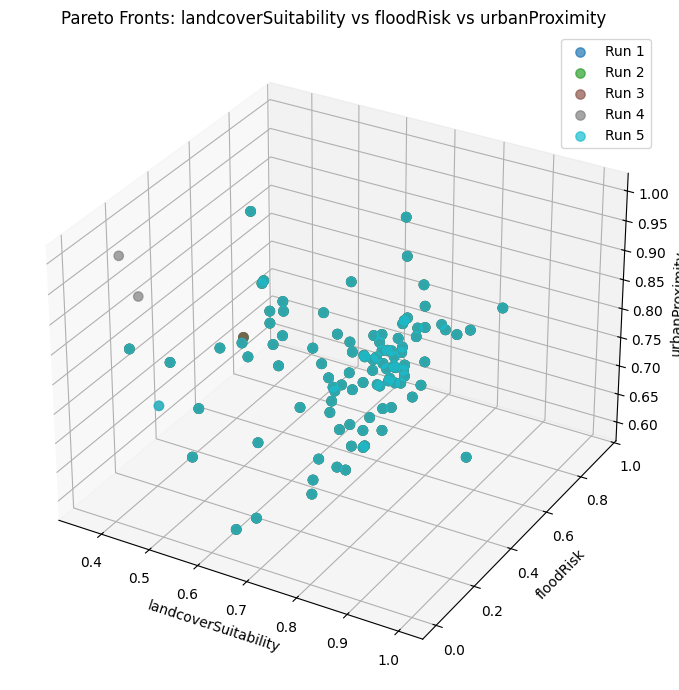

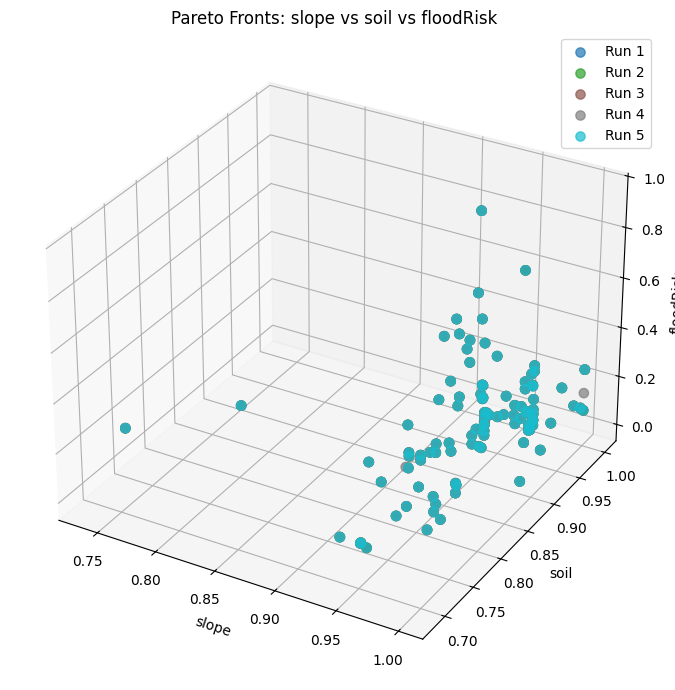

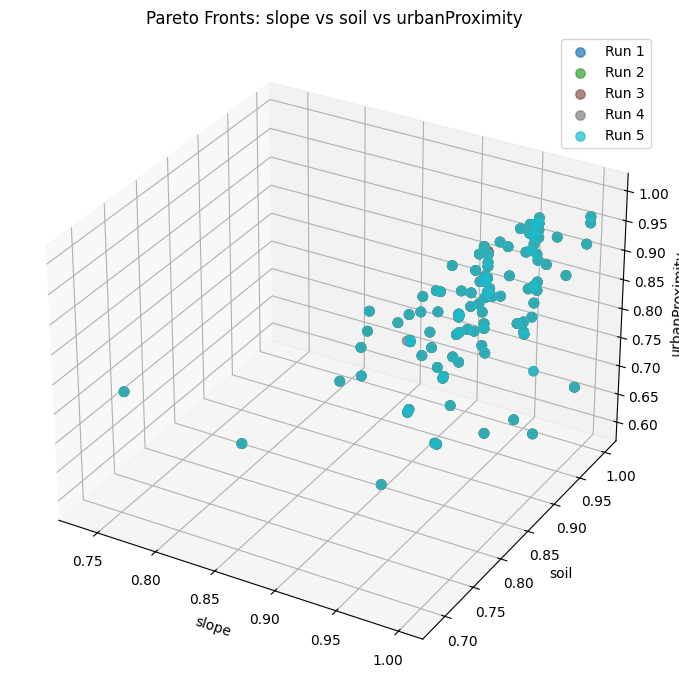

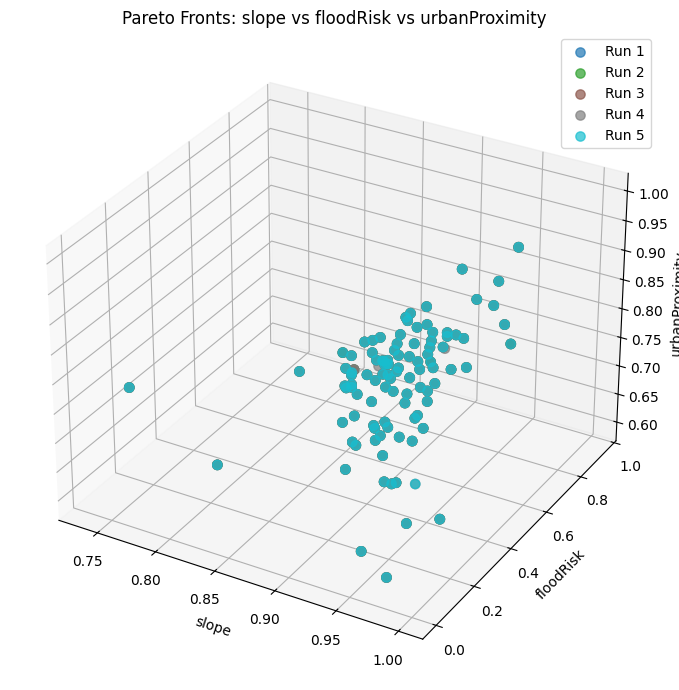

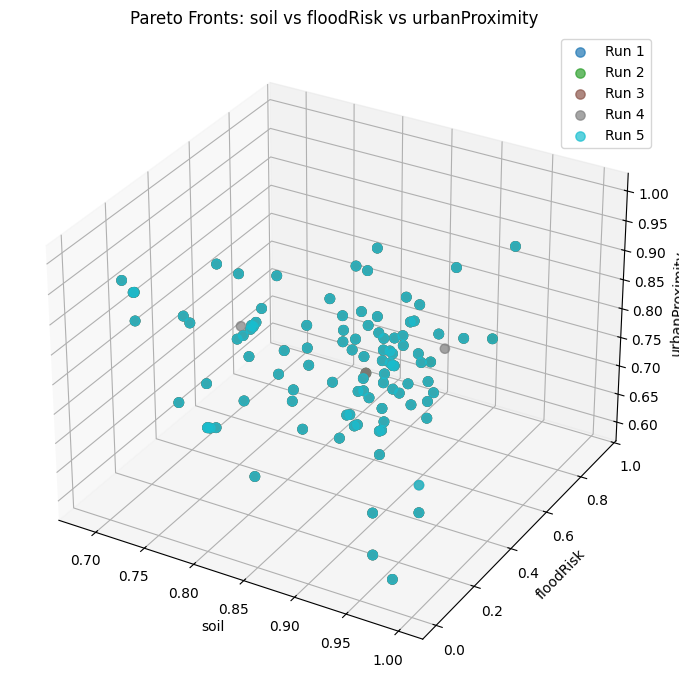

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
import itertools

objective_cols = ['landcoverSuitability', 'slope', 'soil', 'floodRisk', 'urbanProximity']
num_runs = len(hof_all_runs)
colors = plt.cm.tab10(np.linspace(0, 1, num_runs))

# Loop over all unique combinations of 3 objectives
for obj1, obj2, obj3 in itertools.combinations(objective_cols, 3):
    fig = plt.figure(figsize=(9, 7))
    ax = fig.add_subplot(111, projection='3d')
    for run_idx, hof in enumerate(hof_all_runs):
        vals1 = [valid_patches.iloc[p[0]][obj1] for p in hof]
        vals2 = [valid_patches.iloc[p[0]][obj2] for p in hof]
        vals3 = [valid_patches.iloc[p[0]][obj3] for p in hof]
        ax.scatter(vals1, vals2, vals3, color=colors[run_idx], s=45, label=f'Run {run_idx+1}', alpha=0.7)
    ax.set_xlabel(obj1)
    ax.set_ylabel(obj2)
    ax.set_zlabel(obj3)
    ax.set_title(f'Pareto Fronts: {obj1} vs {obj2} vs {obj3}')
    ax.legend()
    plt.tight_layout()
    plt.show()


In [ ]:
import plotly.graph_objects as go
import itertools
import numpy as np

objective_cols = ['landcoverSuitability', 'slope', 'soil', 'floodRisk', 'urbanProximity']
num_runs = len(hof_all_runs)
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'grey', 'olive', 'cyan']  # up to 10 runs

for obj1, obj2, obj3 in itertools.combinations(objective_cols, 3):
    fig = go.Figure()
    all_points = []

    for run_idx, hof in enumerate(hof_all_runs):
        vals1 = [valid_patches.iloc[p[0]][obj1] for p in hof]
        vals2 = [valid_patches.iloc[p[0]][obj2] for p in hof]
        vals3 = [valid_patches.iloc[p[0]][obj3] for p in hof]
        patch_ids = [p[0] for p in hof]
        lons = [valid_patches.iloc[p[0]]['centroid_x'] for p in hof]
        lats = [valid_patches.iloc[p[0]]['centroid_y'] for p in hof]

        hover_text = [
            f"Run: {run_idx+1}<br>Patch ID: {patch_ids[i]}<br>{obj1}: {vals1[i]:.3f}<br>{obj2}: {vals2[i]:.3f}<br>{obj3}: {vals3[i]:.3f}<br>Lon: {lons[i]:.5f}<br>Lat: {lats[i]:.5f}"
            for i in range(len(patch_ids))
        ]

        for i in range(len(patch_ids)):
            all_points.append({
                'run': run_idx+1,
                'patch_id': patch_ids[i],
                'x': vals1[i],
                'y': vals2[i],
                'z': vals3[i],
                'sum': vals1[i] + vals2[i] + vals3[i],
                'lon': lons[i],
                'lat': lats[i],
                'hover': hover_text[i],
                'color': colors[run_idx % len(colors)]
            })

        fig.add_trace(go.Scatter3d(
            x=vals1, y=vals2, z=vals3,
            mode='markers',
            marker=dict(size=5, color=colors[run_idx % len(colors)], opacity=0.7),
            name=f'Run {run_idx+1}',
            text=hover_text,
            hoverinfo='text'
        ))

    # Find top 5 by sum of three objectives (could customize to another score)
    all_points_sorted = sorted(all_points, key=lambda d: d['sum'], reverse=True)
    top5 = all_points_sorted[:5]

    fig.add_trace(go.Scatter3d(
        x=[p['x'] for p in top5],
        y=[p['y'] for p in top5],
        z=[p['z'] for p in top5],
        mode='markers+text',
        marker=dict(size=12, color='gold', symbol='diamond', opacity=1, line=dict(width=2, color='black')),
        text=[f"Top {i+1}<br>{p['hover']}" for i, p in enumerate(top5)],
        name='Top 5',
        hoverinfo='text'
    ))

    # Calculate tight ranges with a small margin
    xvals = [p['x'] for p in all_points]
    yvals = [p['y'] for p in all_points]
    zvals = [p['z'] for p in all_points]
    margin = 0.03  # Adjust as needed
    x_range = [min(xvals) - margin, max(xvals) + margin]
    y_range = [min(yvals) - margin, max(yvals) + margin]
    z_range = [min(zvals) - margin, max(zvals) + margin]

    fig.update_layout(
        title=f'Pareto Fronts (Top 5 Highlighted): {obj1} vs {obj2} vs {obj3}',
        scene=dict(
            xaxis_title=obj1,
            yaxis_title=obj2,
            zaxis_title=obj3,
            aspectmode='cube',
            xaxis=dict(nticks=6, range=x_range),
            yaxis=dict(nticks=6, range=y_range),
            zaxis=dict(nticks=6, range=z_range),
        ),
        legend=dict(itemsizing='constant')
    )
    fig.show()


In [ ]:
import plotly.graph_objects as go
import itertools
import numpy as np

objective_cols = ['landcoverSuitability', 'slope', 'soil', 'floodRisk', 'urbanProximity']
num_runs = len(hof_all_runs)
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'grey', 'olive', 'cyan']  # up to 10 runs

for obj1, obj2, obj3 in itertools.combinations(objective_cols, 3):
    fig = go.Figure()
    # Collect all data for possible highlighting
    all_points = []

    for run_idx, hof in enumerate(hof_all_runs):
        vals1 = [valid_patches.iloc[p[0]][obj1] for p in hof]
        vals2 = [valid_patches.iloc[p[0]][obj2] for p in hof]
        vals3 = [valid_patches.iloc[p[0]][obj3] for p in hof]
        patch_ids = [p[0] for p in hof]
        lons = [valid_patches.iloc[p[0]]['centroid_x'] for p in hof]
        lats = [valid_patches.iloc[p[0]]['centroid_y'] for p in hof]

        # Compose hover text
        hover_text = [
            f"Run: {run_idx+1}<br>Patch ID: {patch_ids[i]}<br>{obj1}: {vals1[i]:.3f}<br>{obj2}: {vals2[i]:.3f}<br>{obj3}: {vals3[i]:.3f}<br>Lon: {lons[i]:.5f}<br>Lat: {lats[i]:.5f}"
            for i in range(len(patch_ids))
        ]

        # Store for global top-5 highlight
        for i in range(len(patch_ids)):
            all_points.append({
                'run': run_idx+1,
                'patch_id': patch_ids[i],
                'x': vals1[i],
                'y': vals2[i],
                'z': vals3[i],
                'sum': vals1[i] + vals2[i] + vals3[i],
                'lon': lons[i],
                'lat': lats[i],
                'hover': hover_text[i],
                'color': colors[run_idx % len(colors)]
            })

        # Plot all points for this run
        fig.add_trace(go.Scatter3d(
            x=vals1, y=vals2, z=vals3,
            mode='markers',
            marker=dict(size=5, color=colors[run_idx % len(colors)], opacity=0.7),
            name=f'Run {run_idx+1}',
            text=hover_text,
            hoverinfo='text'
        ))

    # Find top 5 by sum of three objectives (could customize to another score)
    all_points_sorted = sorted(all_points, key=lambda d: d['sum'], reverse=True)
    top5 = all_points_sorted[:5]

    # Highlight top 5
    fig.add_trace(go.Scatter3d(
        x=[p['x'] for p in top5],
        y=[p['y'] for p in top5],
        z=[p['z'] for p in top5],
        mode='markers+text',
        marker=dict(size=12, color='gold', symbol='diamond', opacity=1, line=dict(width=2, color='black')),
        text=[f"Top {i+1}<br>{p['hover']}" for i, p in enumerate(top5)],
        name='Top 5',
        hoverinfo='text'
    ))

    fig.update_layout(
        title=f'Pareto Fronts (Top 5 Highlighted): {obj1} vs {obj2} vs {obj3}',
        scene=dict(
            xaxis_title=obj1,
            yaxis_title=obj2,
            zaxis_title=obj3,
            aspectmode='cube',
            xaxis=dict(nticks=6, range=[0, 1]),
            yaxis=dict(nticks=6, range=[0, 1]),
            zaxis=dict(nticks=6, range=[0, 1]),
        ),
        legend=dict(itemsizing='constant')
    )
    fig.show()


In [ ]:
import plotly.graph_objects as go

# Choose objectives
obj1 = 'floodRisk'
obj2 = 'landcoverSuitability'
obj3 = 'soil'
run_idx = 0  # Or allow to choose run; here, using the first run

# Collect all Pareto points for all runs (or just one run if you prefer)
all_points = []
for r_idx, hof in enumerate(hof_all_runs):
    for p in hof:
        all_points.append({
            'run': r_idx+1,
            'patch_id': p[0],
            obj1: valid_patches.iloc[p[0]][obj1],
            obj2: valid_patches.iloc[p[0]][obj2],
            obj3: valid_patches.iloc[p[0]][obj3],
            'lon': valid_patches.iloc[p[0]]['centroid_x'],
            'lat': valid_patches.iloc[p[0]]['centroid_y']
        })

# For tight bounding box, get min/max values
x_vals = [pt[obj1] for pt in all_points]
y_vals = [pt[obj2] for pt in all_points]
z_vals = [pt[obj3] for pt in all_points]

buffer = 0.03  # Extra margin for axes
x_range = [min(x_vals)-buffer, max(x_vals)+buffer]
y_range = [min(y_vals)-buffer, max(y_vals)+buffer]
z_range = [min(z_vals)-buffer, max(z_vals)+buffer]

hover_texts = [
    f"Patch: {pt['patch_id']}<br>Flood: {pt[obj1]:.3f}<br>Landcover: {pt[obj2]:.3f}<br>Soil: {pt[obj3]:.3f}<br>Lon: {pt['lon']:.5f}<br>Lat: {pt['lat']:.5f}"
    for pt in all_points
]

fig = go.Figure(data=[go.Scatter3d(
    x=x_vals, y=y_vals, z=z_vals,
    mode='markers',
    marker=dict(size=7, color='royalblue', opacity=0.8),
    text=hover_texts,
    hoverinfo='text'
)])

fig.update_layout(
    title='Pareto Front: Flood Risk vs Landcover Suitability vs Soil',
    scene=dict(
        xaxis=dict(title=obj1, range=x_range),
        yaxis=dict(title=obj2, range=y_range),
        zaxis=dict(title=obj3, range=z_range),
        aspectmode='cube'
    )
)
fig.show()


In [ ]:
# Cell 8: Processing Results with Spatial Filtering
def select_spatially_distributed_patches(population, patch_data, min_distance, num_to_select):
    """Select a subset of patches that are spatially distributed"""
    print("Selecting spatially distributed patches...")

    # Extract unique individuals from the population
    # This helps prevent the "empty range for randrange" error
    unique_individuals = {}
    for ind in population:
        idx = ind[0]
        if idx not in unique_individuals:
            unique_individuals[idx] = ind

    # Convert to list for sorting
    unique_inds = list(unique_individuals.values())

    # We need individuals with valid fitness values
    valid_inds = [ind for ind in unique_inds if hasattr(ind, 'fitness') and ind.fitness.valid]

    if len(valid_inds) == 0:
        print("Warning: No valid individuals found in the population!")
        # Return some random individuals as a fallback
        random_indices = np.random.choice(len(patch_data), min(10, len(patch_data)), replace=False)
        fallback_inds = []
        for idx in random_indices:
            ind = creator.Individual([idx])
            ind.fitness.values = evaluate_individual(ind, patch_data)
            fallback_inds.append(ind)
        valid_inds = fallback_inds

    # Sort by sum of fitness values (simple ranking)
    valid_inds.sort(key=lambda ind: sum(ind.fitness.values), reverse=True)

    # Get centroids for all patches
    selected_patches = []
    selected_centroids = []

    # Always select the best patch first
    if len(valid_inds) > 0:
        best_patch = valid_inds[0]
        best_idx = best_patch[0]
        best_centroid = np.array([[
            patch_data.iloc[best_idx]['centroid_x'],
            patch_data.iloc[best_idx]['centroid_y']
        ]])

        selected_patches.append(best_patch)
        selected_centroids = best_centroid

    # Loop through remaining patches and add them if they're far enough from already selected patches
    for patch in valid_inds[1:]:
        if len(selected_patches) >= num_to_select:
            break

        idx = patch[0]
        centroid = np.array([[
            patch_data.iloc[idx]['centroid_x'],
            patch_data.iloc[idx]['centroid_y']
        ]])

        # Calculate distances to all already selected patches
        if len(selected_centroids) > 0:
            distances = cdist(centroid, selected_centroids).min()

            # If this patch is far enough from all selected patches, add it
            if distances >= min_distance:
                selected_patches.append(patch)
                selected_centroids = np.vstack([selected_centroids, centroid])

    print(f"Selected {len(selected_patches)} spatially distributed patches")

    # If we didn't get enough patches, relax the distance constraint
    if len(selected_patches) < min(num_to_select, 10):
        print("Not enough patches selected. Relaxing distance constraint...")
        relaxed_distance = min_distance / 2

        for patch in valid_inds:
            if patch in selected_patches:
                continue

            if len(selected_patches) >= num_to_select:
                break

            idx = patch[0]
            centroid = np.array([[
                patch_data.iloc[idx]['centroid_x'],
                patch_data.iloc[idx]['centroid_y']
            ]])

            # Calculate distances to all already selected patches
            if len(selected_centroids) > 0:
                distances = cdist(centroid, selected_centroids).min()

                # If this patch is far enough (with relaxed constraint) from all selected patches, add it
                if distances >= relaxed_distance:
                    selected_patches.append(patch)
                    selected_centroids = np.vstack([selected_centroids, centroid])

        print(f"After relaxing distance constraint: Selected {len(selected_patches)} patches")

    return selected_patches

# Select spatially distributed patches
selected_patches = select_spatially_distributed_patches(
    final_population,
    valid_patches,
    MIN_DISTANCE,
    NUM_PATCHES_TO_SELECT
)

Selecting spatially distributed patches...
Selected 5 spatially distributed patches


In [ ]:
# Cell 9: Creating Results DataFrame with Coordinates and Bounding Boxes
def create_results_dataframe(selected_patches, patch_data):
    """Create a DataFrame with results, coordinates, and bounding box coordinates"""
    results = []

    for i, patch in enumerate(selected_patches):
        idx = patch[0]
        patch_row = patch_data.iloc[idx]

        # Get the patch geometry
        patch_geom = patch_row.geometry

        # Get bounding box coordinates in the original CRS
        minx, miny, maxx, maxy = patch_geom.bounds

        # Convert to EPSG:25831 if not already in that CRS
        if patch_data.crs != 'EPSG:25831':
            # Convert geometry to EPSG:25831
            patch_gdf_single = gpd.GeoDataFrame([patch_row], geometry='geometry', crs=patch_data.crs)
            patch_gdf_utm = patch_gdf_single.to_crs('EPSG:25831')
            patch_geom_utm = patch_gdf_utm.geometry.iloc[0]
            minx_utm, miny_utm, maxx_utm, maxy_utm = patch_geom_utm.bounds

            # Also get centroid in UTM coordinates
            centroid_utm = patch_geom_utm.centroid
            centroid_x_utm = centroid_utm.x
            centroid_y_utm = centroid_utm.y
        else:
            # Already in EPSG:25831
            minx_utm, miny_utm, maxx_utm, maxy_utm = minx, miny, maxx, maxy
            centroid_x_utm = patch_row['centroid_x']
            centroid_y_utm = patch_row['centroid_y']

        results.append({
            'rank': i + 1,
            'patch_id': idx,
            'centroid_longitude': patch_row['centroid_x'],
            'centroid_latitude': patch_row['centroid_y'],
            'centroid_x_utm31n': centroid_x_utm,
            'centroid_y_utm31n': centroid_y_utm,
            'bbox_minx_utm31n': minx_utm,
            'bbox_miny_utm31n': miny_utm,
            'bbox_maxx_utm31n': maxx_utm,
            'bbox_maxy_utm31n': maxy_utm,
            'bbox_coordinates_utm31n': f"{minx_utm:.2f},{miny_utm:.2f},{maxx_utm:.2f},{maxy_utm:.2f}",
            'landcoverSuitability': patch_row['landcoverSuitability'],
            'slope': patch_row['slope'],
            'soil': patch_row['soil'],
            'floodRisk': patch_row['floodRisk'],
            'urbanProximity': patch_row['urbanProximity'],
            'overall_score': sum(patch.fitness.values) if hasattr(patch, 'fitness') and patch.fitness.valid else 0
        })

    results_df = pd.DataFrame(results)

    # Display the top results
    print("\nTop 10 selected patches with bounding box coordinates:")
    display_cols = ['rank', 'patch_id', 'centroid_x_utm31n', 'centroid_y_utm31n', 'bbox_coordinates_utm31n', 'overall_score']
    print(results_df[display_cols].head(10).to_string(index=False))

    return results_df

# Create results DataFrame with bounding boxes
results_df = create_results_dataframe(selected_patches, valid_patches)

# Additional function to export bounding box coordinates for easy copying
def export_bounding_boxes(results_df, filename='/content/bounding_boxes_utm31n.txt'):
    """Export bounding box coordinates in a format ready for bounding box tools"""
    with open(filename, 'w') as f:
        f.write("# Bounding Box Coordinates for Optimal Afforestation Patches\n")
        f.write("# Format: minx,miny,maxx,maxy (EPSG:25831 - ETRS89 / UTM zone 31N)\n")
        f.write("# Units: meters\n\n")

        for _, row in results_df.head(20).iterrows():  # Export top 20 patches
            f.write(f"# Patch {row['patch_id']} (Rank {row['rank']}) - Score: {row['overall_score']:.3f}\n")
            f.write(f"{row['bbox_coordinates_utm31n']}\n\n")

    print(f"\nBounding box coordinates exported to: {filename}")
    print("Format: minx,miny,maxx,maxy (EPSG:25831 - ETRS89 / UTM zone 31N)")
    print("Units: meters")

    # Also display the first 5 for immediate use
    print("\nFirst 5 bounding boxes for immediate copying:")
    for i, row in results_df.head(5).iterrows():
        print(f"Patch {row['patch_id']}: {row['bbox_coordinates_utm31n']}")

# Export bounding box coordinates
export_bounding_boxes(results_df)


Top 10 selected patches with bounding box coordinates:
 rank  patch_id  centroid_x_utm31n  centroid_y_utm31n                   bbox_coordinates_utm31n  overall_score
    1        65      496780.526947       4.656876e+06 496248.24,4656344.01,497312.82,4657408.59       4.320733
    2       137      507299.933082       4.650139e+06 506767.75,4649607.32,507832.12,4650671.69       4.255995
    3        85      499694.100275       4.655672e+06 499161.84,4655139.43,500226.37,4656203.97       4.212922
    4         7      508280.401567       4.664061e+06 507748.14,4663529.06,508812.67,4664593.59       4.128378
    5       135      507369.887671       4.651134e+06 506837.70,4650601.73,507902.08,4651666.11       4.119386

Bounding box coordinates exported to: /content/bounding_boxes_utm31n.txt
Format: minx,miny,maxx,maxy (EPSG:25831 - ETRS89 / UTM zone 31N)
Units: meters

First 5 bounding boxes for immediate copying:
Patch 65: 496248.24,4656344.01,497312.82,4657408.59
Patch 137: 506767.75,46496

Creating flood mitigation potential map...


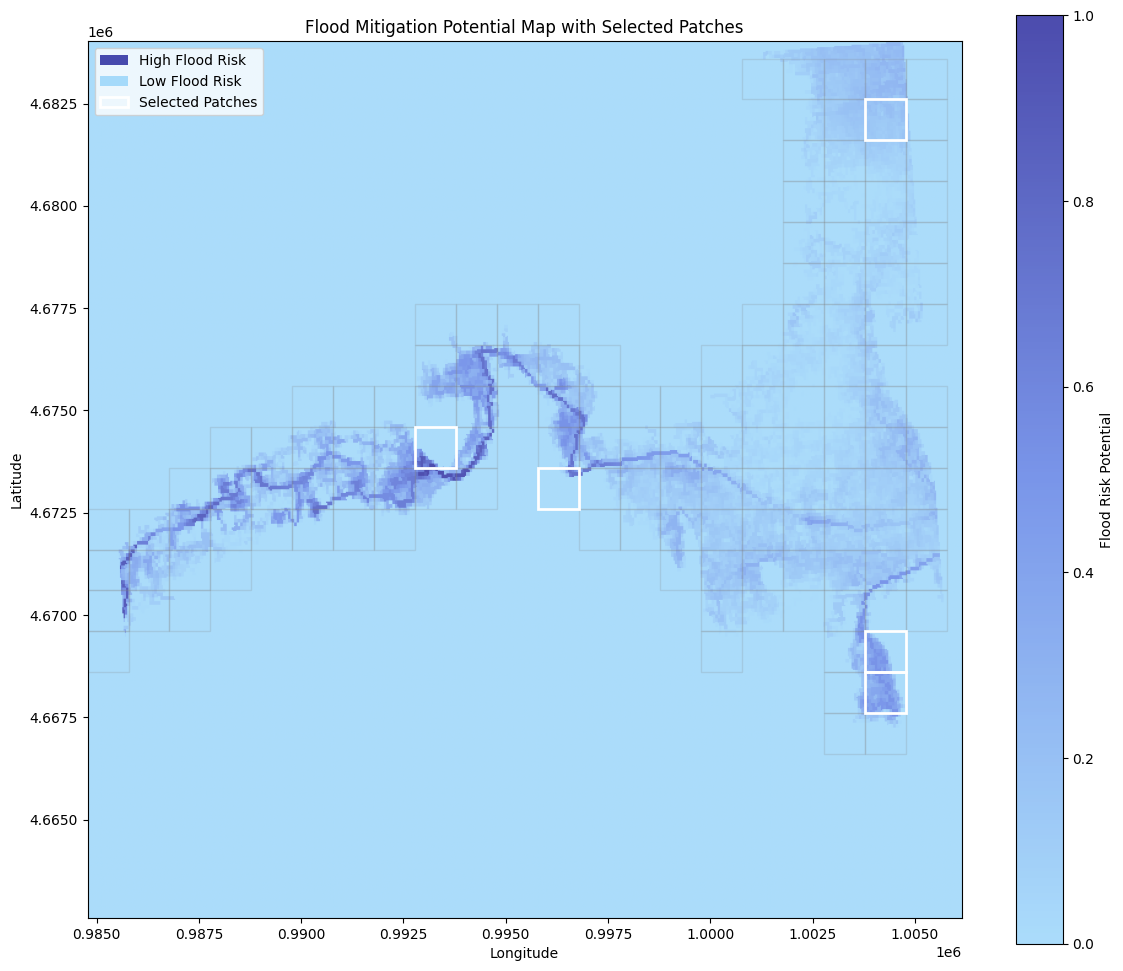

In [ ]:
# Cell 10: Enhanced Visualization - Flood Mitigation Potential Map
def create_flood_mitigation_map(patch_data, selected_patches, rasters):
    """Create a map showing flood mitigation potential and selected patches"""
    print("Creating flood mitigation potential map...")

    # Get base raster for display
    flood_risk_data = rasterio.open(files['floodRisk'])
    flood_data = flood_risk_data.read(1)

    # Create a figure
    plt.figure(figsize=(12, 10))

    # Show flood risk background
    flood_cmap = LinearSegmentedColormap.from_list('flood_cmap', ['lightskyblue', 'royalblue', 'darkblue'])
    plt.imshow(flood_data, cmap=flood_cmap, alpha=0.7, extent=rasterio.plot.plotting_extent(flood_risk_data))
    plt.colorbar(label='Flood Risk Potential')

    # Plot all patches with low opacity
    patch_data.plot(ax=plt.gca(), facecolor='none', edgecolor='grey', alpha=0.2)

    # Highlight selected patches
    for patch in selected_patches:
        idx = patch[0]
        selected_geom = patch_data.iloc[idx].geometry
        x, y = selected_geom.exterior.xy
        plt.fill(x, y, facecolor='none', edgecolor='white', linewidth=2)

    plt.title('Flood Mitigation Potential Map with Selected Patches')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')

    # Add a legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='darkblue', alpha=0.7, label='High Flood Risk'),
        Patch(facecolor='lightskyblue', alpha=0.7, label='Low Flood Risk'),
        Patch(facecolor='none', edgecolor='white', linewidth=2, label='Selected Patches')
    ]
    plt.legend(handles=legend_elements)

    plt.tight_layout()
    plt.show()
    # Create flood mitigation potential map
create_flood_mitigation_map(valid_patches, selected_patches, rasters)

Creating MCDA map with NSGA-II selected patches (viridis colormap)...


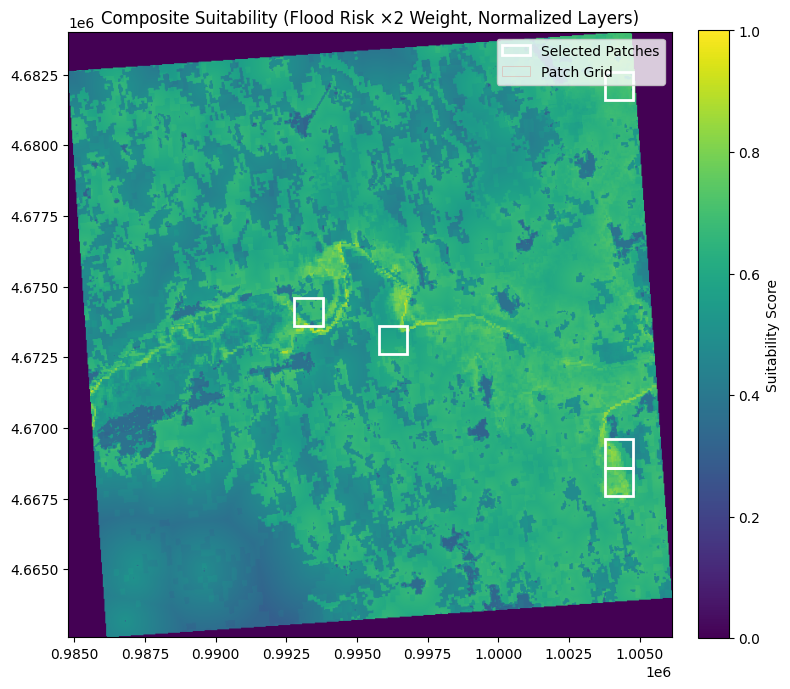

In [ ]:
# Overlay NSGA-II Selected Patches on MCDA Composite Suitability Map (Viridis Colormap)

import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import rasterio.plot

def plot_mcda_with_nsgaii_overlay(patch_data, selected_patches, composite_norm, rasters):
    """
    Plots MCDA composite map (viridis colormap), shows all patches in light red,
    and highlights NSGA-II selected patches in white.
    """
    print("Creating MCDA map with NSGA-II selected patches (viridis colormap)...")

    extent = rasterio.plot.plotting_extent(rasters['floodRisk'])

    plt.figure(figsize=(8, 8))
    im = plt.imshow(composite_norm, cmap='viridis', vmin=0, vmax=1, extent=extent)
    plt.title("Composite Suitability (Flood Risk ×2 Weight, Normalized Layers)")
    plt.axis('on')  # show geospatial axes

    # Colorbar with good sizing
    cbar = plt.colorbar(im, fraction=0.046, pad=0.04)
    cbar.set_label('Suitability Score')

    # Optionally overlay all patch boundaries in light red (as in your MCDA cell)
    if 'patch_grid' in locals() and hasattr(patch_grid, "geometry"):
        for geom in patch_grid.geometry:
            x, y = geom.exterior.xy
            plt.plot(x, y, color='red', linewidth=0.5, alpha=0.2)

    # Highlight selected patches (NSGA-II results) in white
    for patch in selected_patches:
        idx = patch[0]
        selected_geom = patch_data.iloc[idx].geometry
        if selected_geom.geom_type == "Polygon":
            x, y = selected_geom.exterior.xy
            plt.fill(x, y, facecolor='none', edgecolor='white', linewidth=2)
        elif selected_geom.geom_type == "MultiPolygon":
            for poly in selected_geom.geoms:
                x, y = poly.exterior.xy
                plt.fill(x, y, facecolor='none', edgecolor='white', linewidth=2)

    # Legend
    legend_elements = [
        Patch(facecolor='none', edgecolor='white', linewidth=2, label='Selected Patches'),
        Patch(facecolor='none', edgecolor='red', linewidth=0.5, alpha=0.2, label='Patch Grid')
    ]
    plt.legend(handles=legend_elements, loc='upper right')

    plt.tight_layout()
    plt.show()

# Usage
plot_mcda_with_nsgaii_overlay(valid_patches, selected_patches, composite_norm, rasters)


In [ ]:
# Cell 11: Interactive Map with Leafmap
def create_interactive_map(results_df, patch_data):
    """Create an interactive map using leafmap"""
    print("Creating interactive map...")

    # Get all geometries for selected patches
    selected_geoms = []
    for _, row in results_df.iterrows():
        patch_id = row['patch_id']

        # Convert patch_id to int if it's not already
        try:
            patch_id = int(patch_id)
        except (ValueError, TypeError):
            print(f"Warning: patch_id '{patch_id}' is not an integer. Using .loc instead of .iloc")
            # If we can't convert to int, try to find the row using .loc instead
            if patch_id in patch_data.index:
                selected_geoms.append(patch_data.loc[patch_id].geometry)
                continue
            else:
                print(f"Warning: patch_id '{patch_id}' not found in patch_data index. Skipping.")
                continue

        # Check if the index is within range
        if 0 <= patch_id < len(patch_data):
            selected_geoms.append(patch_data.iloc[patch_id].geometry)
        else:
            print(f"Warning: patch_id {patch_id} is out of range. Skipping.")

    # Make sure we have at least one geometry
    if len(selected_geoms) == 0:
        print("No valid geometries found! Creating a fallback geometry.")
        # Create a simple square as a fallback
        from shapely.geometry import box
        x_mean = results_df['longitude'].mean()
        y_mean = results_df['latitude'].mean()
        selected_geoms = [box(x_mean-0.01, y_mean-0.01, x_mean+0.01, y_mean+0.01)]

    # Create GeoDataFrame with selected patches
    selected_gdf = gpd.GeoDataFrame({
        'rank': results_df['rank'],
        'patch_id': results_df['patch_id'],
        'longitude': results_df['longitude'],
        'latitude': results_df['latitude'],
        'score': results_df['overall_score']
    }, geometry=selected_geoms, crs=patch_data.crs)

    # Convert to WGS84 for mapping
    try:
        selected_gdf = selected_gdf.to_crs('EPSG:4326')
    except Exception as e:
        print(f"Warning: Could not convert CRS. Using original CRS. Error: {e}")

    # Create a leafmap
    m = leafmap.Map()

    # Add selected patches
    m.add_gdf(selected_gdf, layer_name="Selected Patches", fill_colors=['white'], info_mode='on_hover',
              hover_style={'fillColor': 'yellow'})

    # Find center of selected patches for map centering
    try:
        center_lat = selected_gdf.geometry.centroid.y.mean()
        center_lon = selected_gdf.geometry.centroid.x.mean()
        m.set_center(center_lon, center_lat, zoom=10)
    except Exception as e:
        print(f"Warning: Could not set map center. Error: {e}")

    # Display map
    display(m)

    return m

# Create interactive map
try:
    interactive_map = create_interactive_map(results_df, valid_patches)
except Exception as e:
    print(f"Error creating interactive map: {e}")
    print("Skipping interactive map creation and continuing with the rest of the analysis.")

Creating interactive map...
Error creating interactive map: 'longitude'
Skipping interactive map creation and continuing with the rest of the analysis.


Analyzing objective trade-offs...


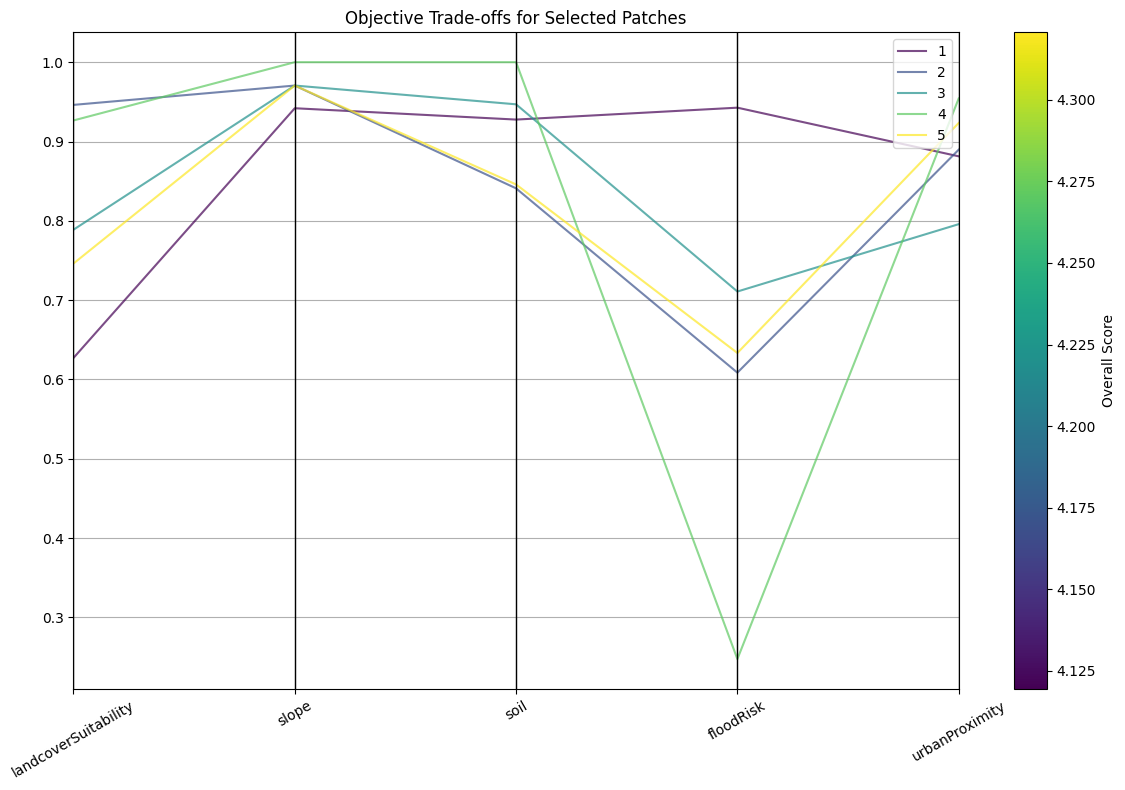

In [ ]:
# Cell 12: Analysis of Objective Trade-offs
def analyze_objective_tradeoffs(results_df):
    """Analyze and visualize trade-offs between objectives"""
    print("Analyzing objective trade-offs...")

    # Set up plot
    fig = plt.figure(figsize=(12, 8))

    # Select columns for parallel coordinates plot
    objective_cols = [
        'landcoverSuitability',
        'slope',
        'soil',
        'floodRisk',
        'urbanProximity'
    ]

    # Create a colormap based on overall score
    norm = plt.Normalize(results_df['overall_score'].min(), results_df['overall_score'].max())
    colors = plt.cm.viridis(norm(results_df['overall_score']))

    # Plot parallel coordinates
    # Get the axes object from the parallel_coordinates plot
    ax = pd.plotting.parallel_coordinates(
        results_df,
        'rank',
        cols=objective_cols,
        colormap=plt.cm.viridis,
        alpha=0.7
    )

    plt.title('Objective Trade-offs for Selected Patches')
    plt.grid(True)
    plt.xticks(rotation=30)

    # Add colorbar for overall score, explicitly linking it to the axes
    sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax) # Pass the axes object to the colorbar call
    cbar.set_label('Overall Score')

    plt.tight_layout()
    plt.show()

# Analyze objective trade-offs
analyze_objective_tradeoffs(results_df)

In [ ]:
# Cell 13: Export Results
def export_results(results_df, patch_data, selected_patches):
    """Export the results to CSV file"""
    print("Exporting results...")

    # Save results DataFrame to CSV
    results_df.to_csv('/content/selected_patches_results.csv', index=False)
    print("Results saved to 'selected_patches_results.csv'")

    # Create a GeoDataFrame with selected patches
    selected_geoms = []
    for patch in selected_patches:
        idx = patch[0]
        selected_geoms.append(patch_data.iloc[idx].geometry)

    selected_gdf = gpd.GeoDataFrame(
        results_df,
        geometry=selected_geoms,
        crs=patch_data.crs
    )

    # Save as GeoJSON
    selected_gdf.to_file('/content/selected_patches.geojson', driver='GeoJSON')
    print("GeoJSON saved to 'selected_patches.geojson'")

    return True

# Export results
export_results(results_df, valid_patches, selected_patches)


Exporting results...
Results saved to 'selected_patches_results.csv'
GeoJSON saved to 'selected_patches.geojson'


True

Analyzing top 10 patches...


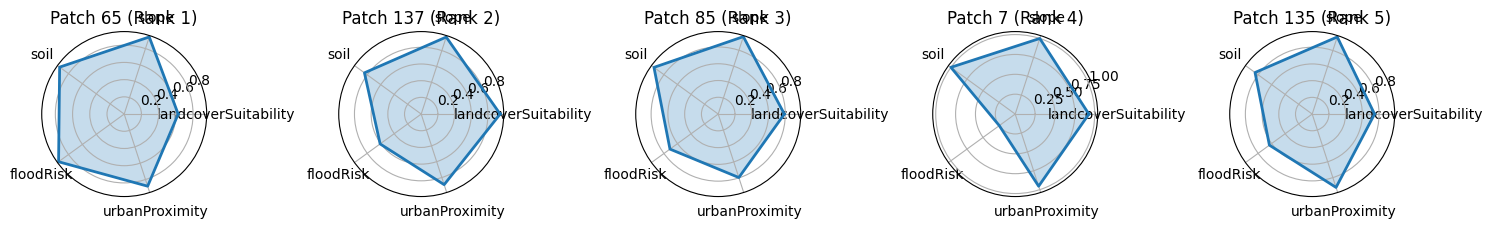


Top Patches Metrics Comparison:
 rank  patch_id  centroid_longitude  centroid_latitude  landcoverSuitability    slope     soil  floodRisk  urbanProximity  overall_score
    1        65            993280.0          4674100.0              0.627171 0.941941 0.927643   0.942647        0.881331       4.320733
    2       137           1004280.0          4668100.0              0.946166 0.970537 0.840945   0.608638        0.889709       4.255995
    3        85            996280.0          4673100.0              0.788806 0.970537 0.946880   0.710894        0.795804       4.212922
    4         7           1004280.0          4682100.0              0.926530 1.000000 1.000000   0.247596        0.954253       4.128378
    5       135           1004280.0          4669100.0              0.746193 0.970537 0.845884   0.633422        0.923350       4.119386

NSGA-II optimization for flood mitigation through afforestation complete!
You now have the coordinates and characteristics of the optimal patche

In [ ]:
# Cell 14: Detailed Analysis of Top Patches
def analyze_top_patches(results_df, num_top=10):
    """Analyze top patches in detail"""
    print(f"Analyzing top {num_top} patches...")

    # Get top patches
    top_patches = results_df.head(num_top)

    # Set up plot
    fig = plt.figure(figsize=(15, 10))

    # Create a radar chart for each patch
    objective_cols = [
        'landcoverSuitability',
        'slope',
        'soil',
        'floodRisk',
        'urbanProximity'
    ]

    # Number of variables
    N = len(objective_cols)

    # Create radar chart
    angles = np.linspace(0, 2*np.pi, N, endpoint=False).tolist()
    angles += angles[:1]  # Close the loop

    # Plot each patch
    for i, (_, patch) in enumerate(top_patches.iterrows()):
        values = patch[objective_cols].values.flatten().tolist()
        values += values[:1]  # Close the loop

        ax = fig.add_subplot(2, 5, i+1, polar=True)
        ax.plot(angles, values, linewidth=2, label=f"Rank {patch['rank']}")
        ax.fill(angles, values, alpha=0.25)

        # Set labels
        ax.set_thetagrids(np.degrees(angles[:-1]), objective_cols)
        ax.set_title(f"Patch {patch['patch_id']} (Rank {patch['rank']})")
        ax.grid(True)

    plt.tight_layout()
    plt.show()

    # Create a metrics comparison table
    print("\nTop Patches Metrics Comparison:")
    comparison_cols = [
        'rank',
        'patch_id',
        'centroid_longitude',
        'centroid_latitude'
    ] + objective_cols + ['overall_score']
    comparison_df = top_patches[comparison_cols]
    print(comparison_df.to_string(index=False))

    return comparison_df

# Analyze top patches
top_patches_analysis = analyze_top_patches(results_df)

print("\nNSGA-II optimization for flood mitigation through afforestation complete!")
print("You now have the coordinates and characteristics of the optimal patches for afforestation.")
